In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils.CaImageCSV import CaImageCSV
import utils.sulfur.constant as const

from utils.TimeCorrelationCalculator import TimeCorrelationCalculator
from utils.TimeCorrelationViewer import TimeCorrelationViewer

In [2]:
def calculate_cell_correlation(df, frame_index, size=9):
    sliding_window = df.iloc[frame_index:frame_index+size, :]
    return sliding_window.corr()

In [3]:
def calc_time_correlation(seconds, correlation_for_time, correlation_for_cells):
    for i in range(seconds):
        i_time_data = correlation_for_cells[i]
        for j in range(seconds):
            j_time_data = correlation_for_cells[j]

            if correlation_for_time.at[j, i] is not np.nan:
                correlation_for_time.at[i, j] = correlation_for_time.at[j, i]
                continue

            cell_count = len(i_time_data)
            calculated_values = i_time_data * j_time_data
            corr_sum = (calculated_values - (calculated_values * np.eye(len(calculated_values)))).sum().sum()
            if correlation_for_time.at[i, j] is np.nan:
                correlation_for_time.at[i, j] = 0.0
            correlation_for_time.at[i, j] += corr_sum / (cell_count * (cell_count - 1))

In [4]:
def view_between_es_correlation(context_name, csv):
    A1preES_context_data = csv.filtered_by_context('%spreES' % context_name)
    A1postES_context_data = csv.filtered_by_context('%spostES' % context_name)
    
    between_context_df = pd.DataFrame(columns=A1preES_context_data.columns)
    between_context_df = between_context_df.append(A1preES_context_data.iloc[2601:3001, :], ignore_index=True)
    between_context_df = between_context_df.append(A1postES_context_data.iloc[0:400, :], ignore_index=True)
    between_context_df
    
    df = csv.optimize_std(between_context_df.astype(float).copy(deep=True))
    engram_df = df.loc[:, csv.engram_cells()]
    non_engram_df = df.loc[:, csv.non_engram_cells()]
    
    engram_df.dropna(how='all', axis=1, inplace=True)
    engram_df.fillna(0.0, inplace=True, axis=1)
    non_engram_df.dropna(how='all', axis=1, inplace=True)
    non_engram_df.fillna(0.0, inplace=True, axis=1)
    
    start = 0
    end = 80
    seconds = end - start
    
    corr_df_for_engram = pd.DataFrame(columns=list(range(seconds)), index=list(range(seconds)))
    corr_df_for_non_engram = pd.DataFrame(columns=list(range(seconds)), index=list(range(seconds)))
    
    engram_cells_correlations = []
    non_engram_cells_correlations = []
    for second in range(start, end):
        frame_index = second * 10
        engram_corr = calculate_cell_correlation(engram_df, frame_index)
        non_engram_corr = calculate_cell_correlation(non_engram_df, frame_index)
    
        engram_cells_correlations.append(engram_corr)
        non_engram_cells_correlations.append(non_engram_corr)
    
    calc_time_correlation(seconds, corr_df_for_engram, engram_cells_correlations)
    calc_time_correlation(seconds, corr_df_for_non_engram, non_engram_cells_correlations)
    
    corr_df_for_shuffle = pd.DataFrame(columns=list(range(seconds)), index=list(range(seconds)))
    for n in range(1000):
        random_cells = np.random.randint(0, len(df.columns), size=len(engram_df.columns))
        shuffle_df = df.iloc[:, random_cells].copy(deep=True)
        shuffle_cells_correlations = []
        for second in range(start, end):
            frame_index = second * 10
            shuffle_corr = calculate_cell_correlation(shuffle_df, frame_index)
    
            shuffle_cells_correlations.append(shuffle_corr)
    
        calc_time_correlation(seconds, corr_df_for_shuffle, shuffle_cells_correlations)
    
    corr_df_for_shuffle /= 1000
    
    viewer = TimeCorrelationViewer(corr_df_for_shuffle, corr_df_for_engram, corr_df_for_non_engram, ticks_span=10)
    viewer.view_heatmap(title='%spreES-%spostES in %s' % (context_name, context_name, animal_name))
    viewer.view_sum_of_correlation_bar()
    
    return [corr_df_for_shuffle, corr_df_for_engram, corr_df_for_non_engram]

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

CPU times: user 43min 4s, sys: 1min 8s, total: 44min 12s
Wall time: 41min 51s


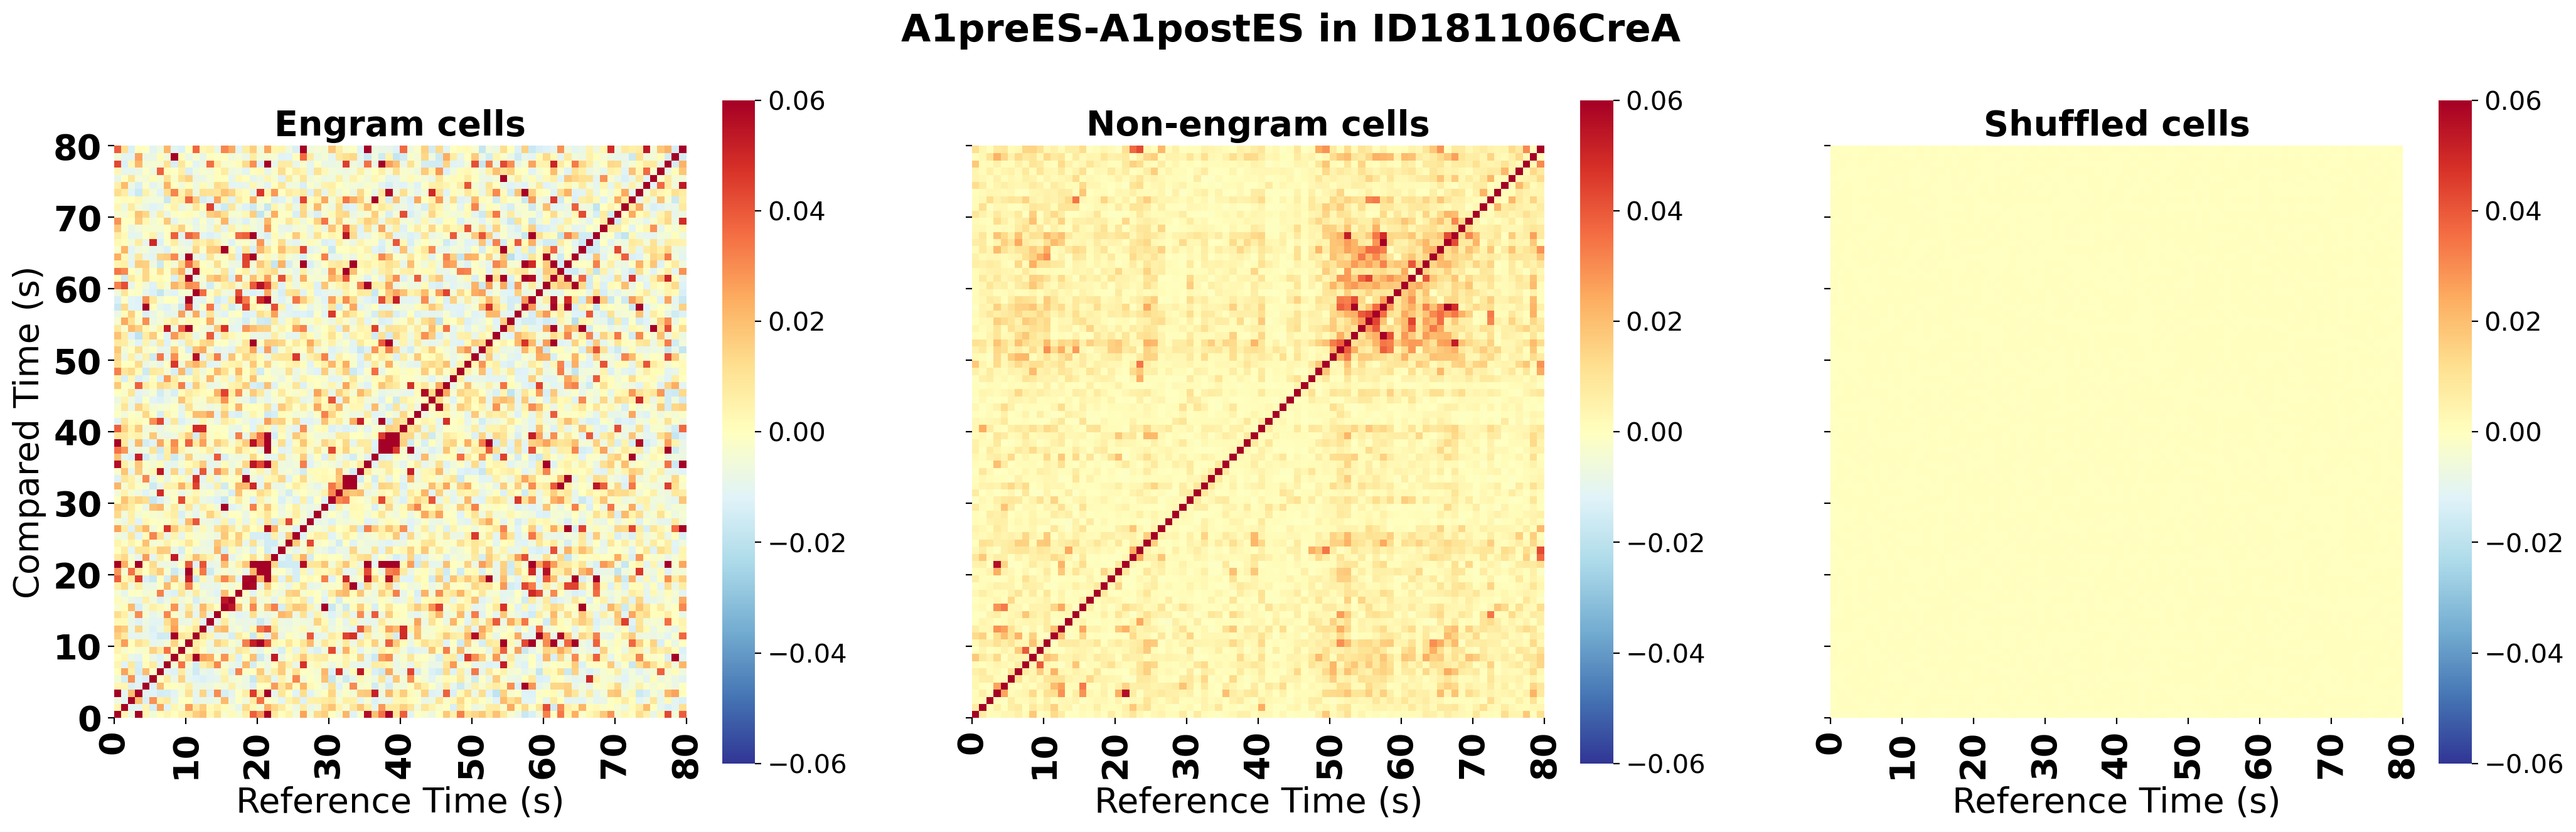

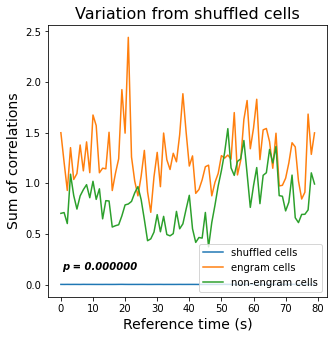

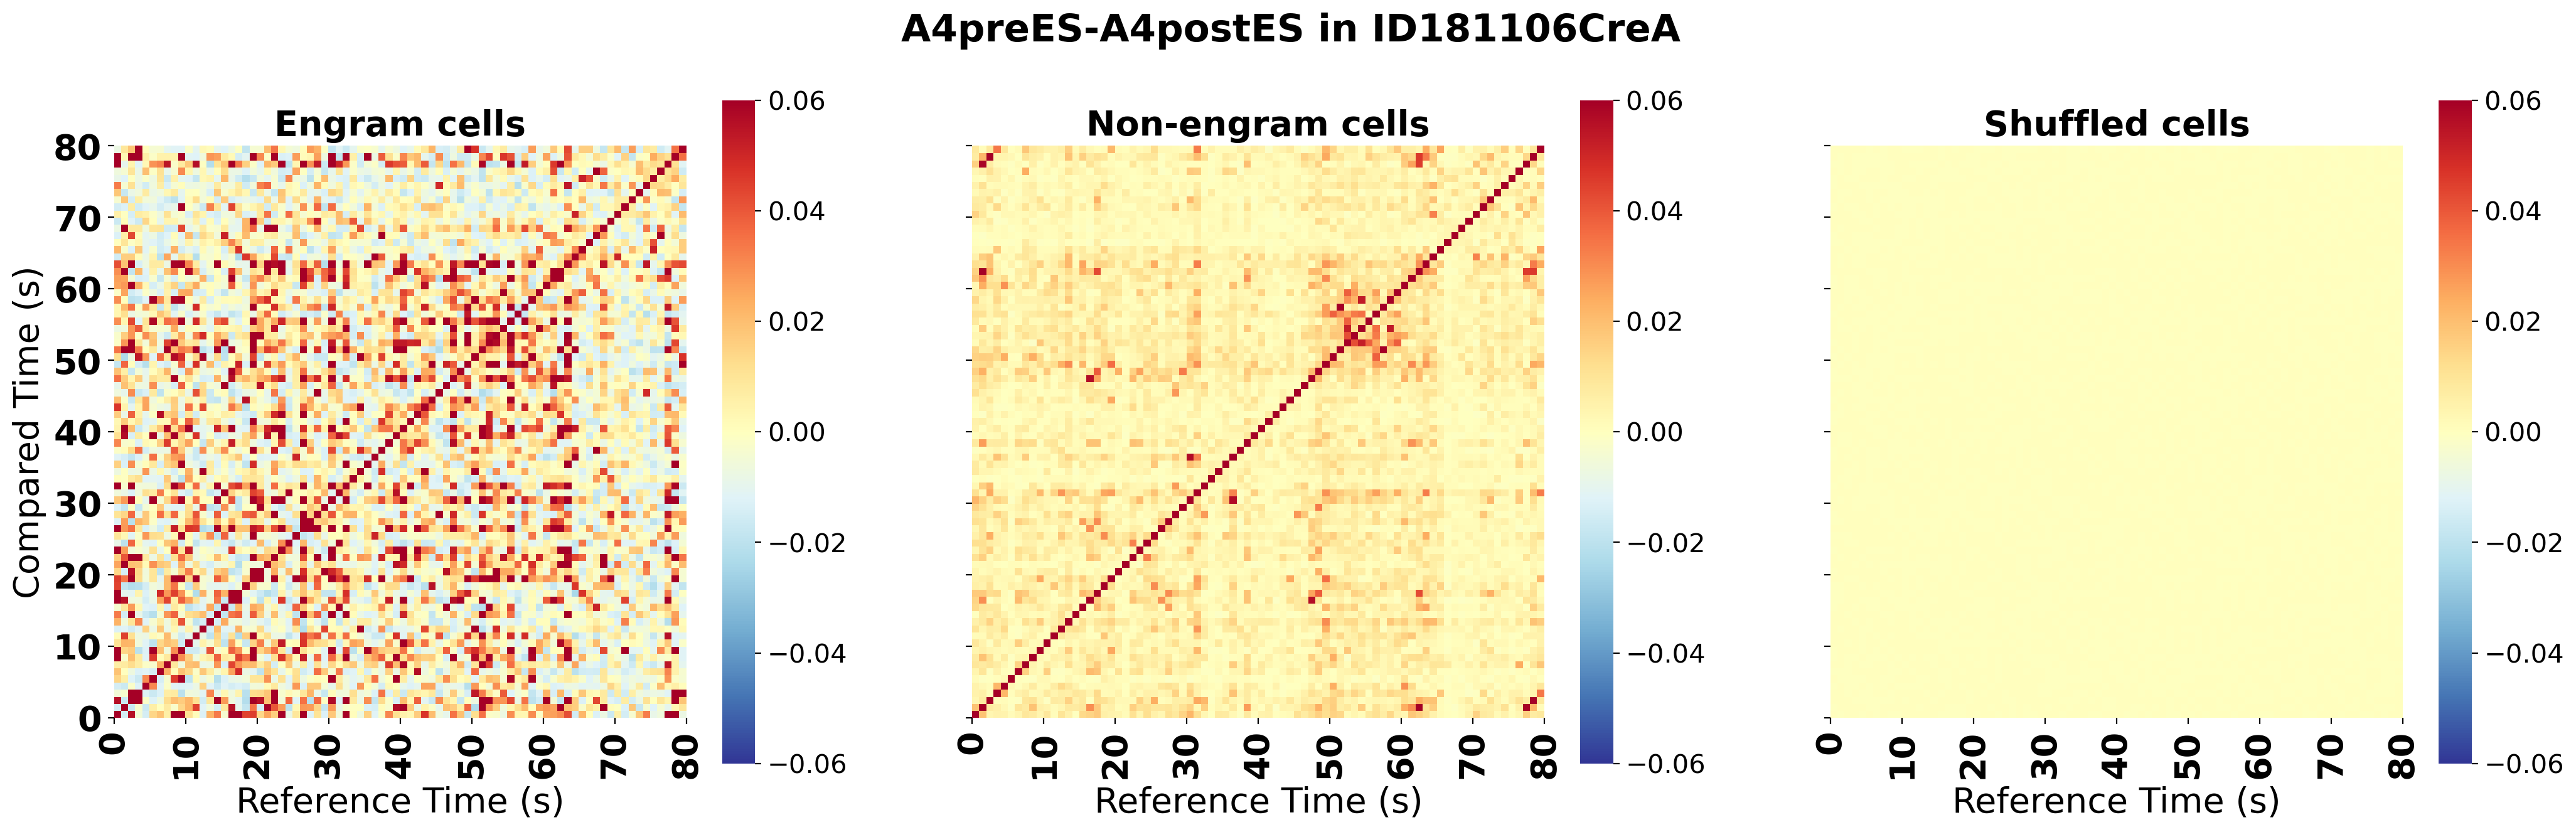

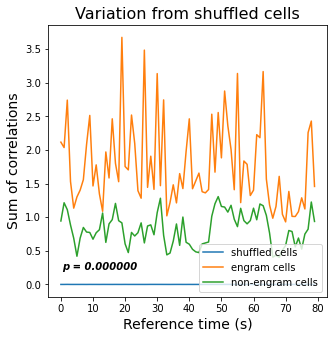

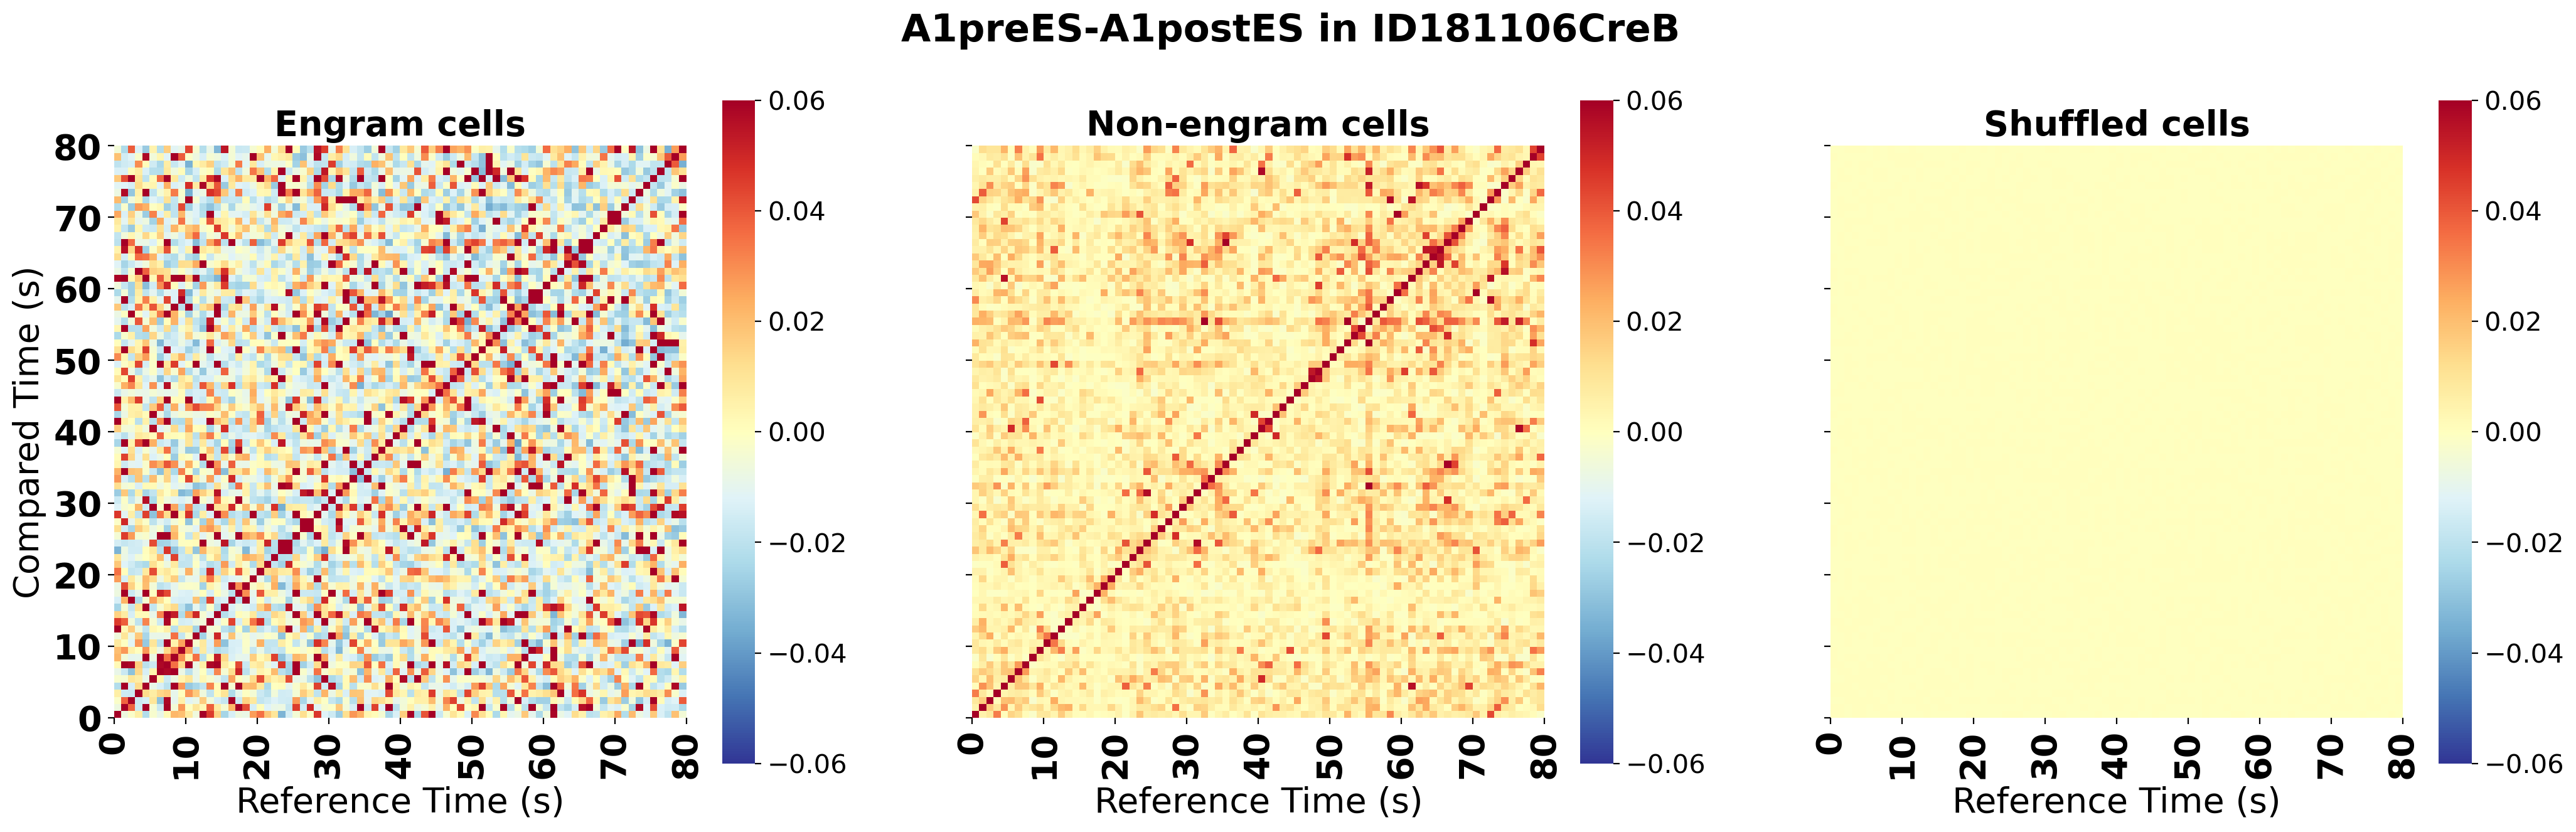

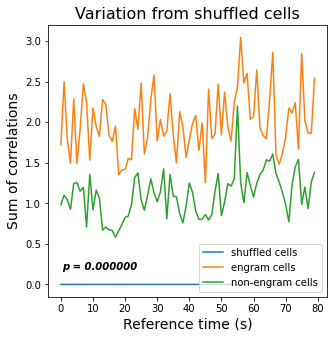

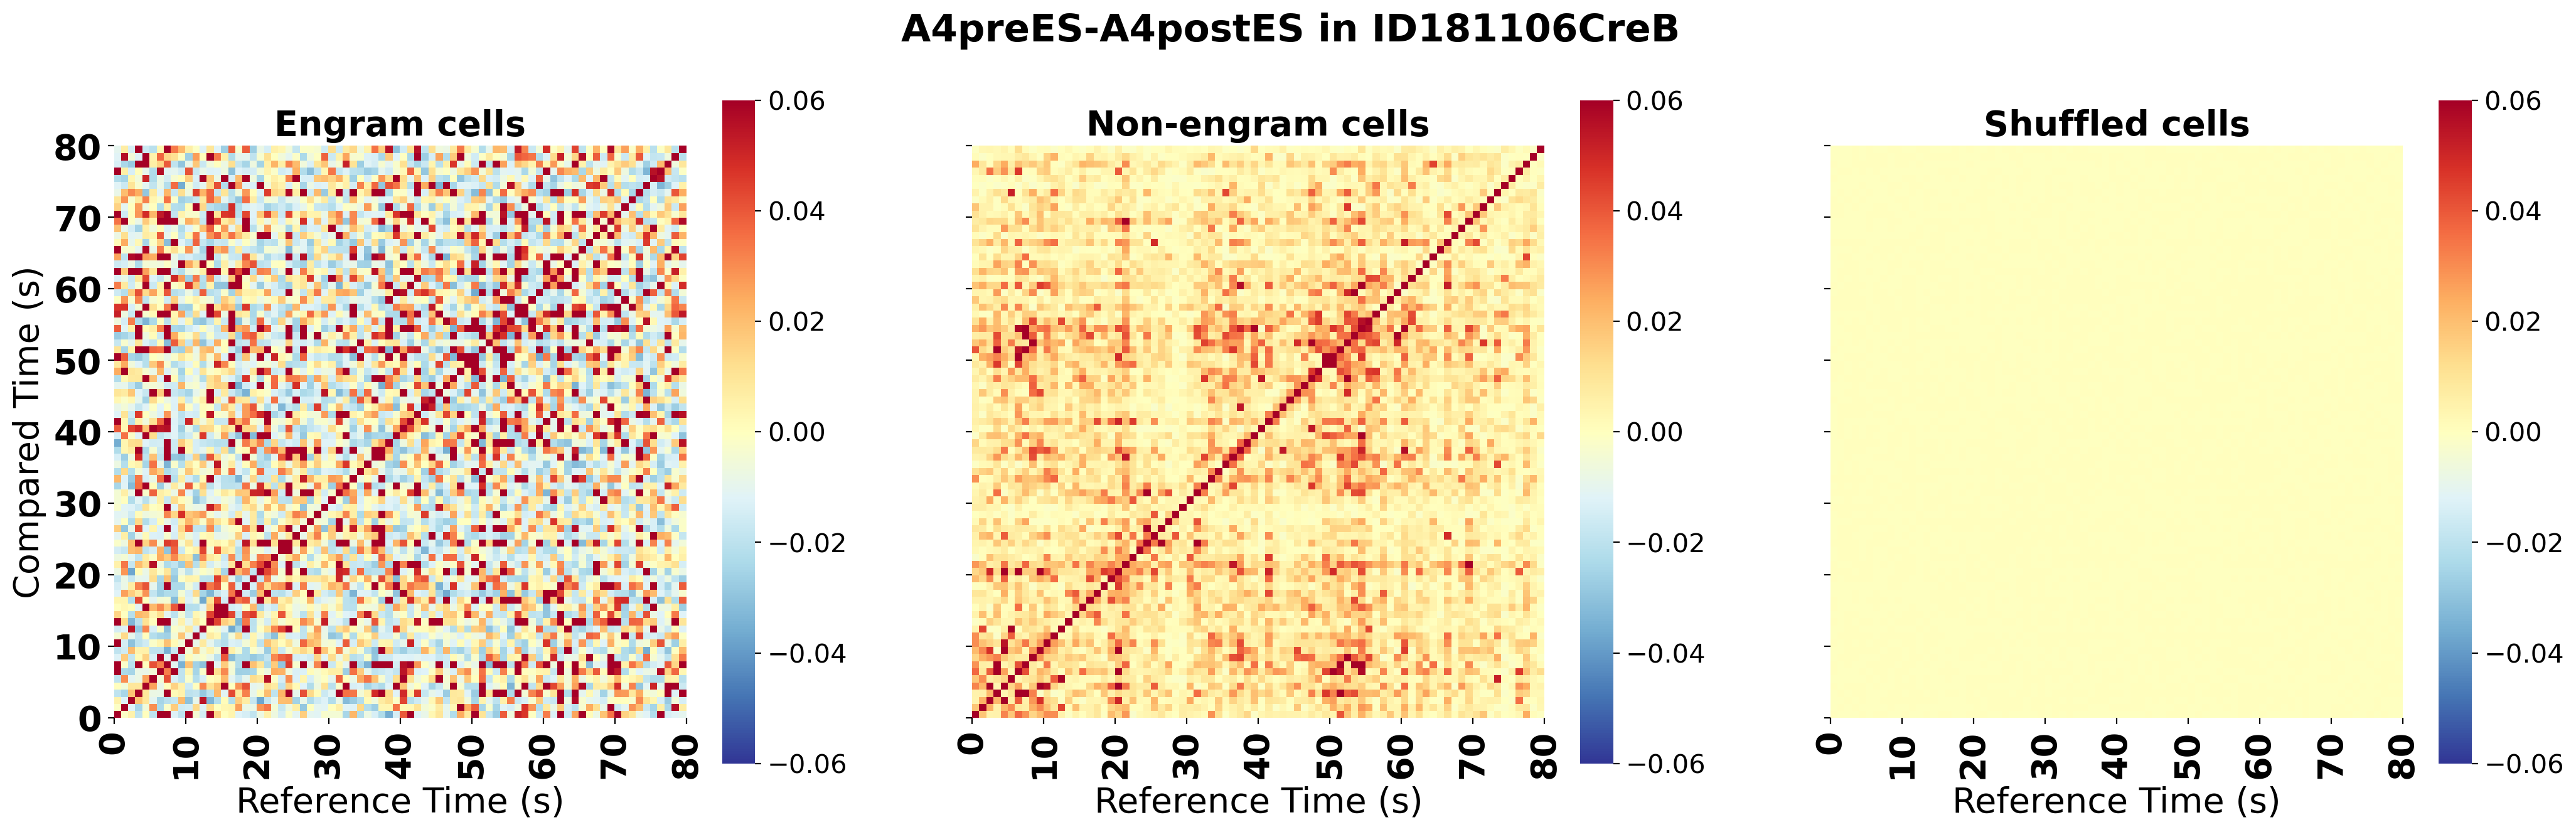

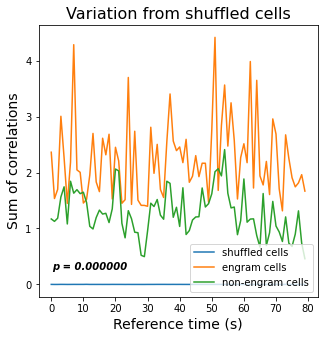

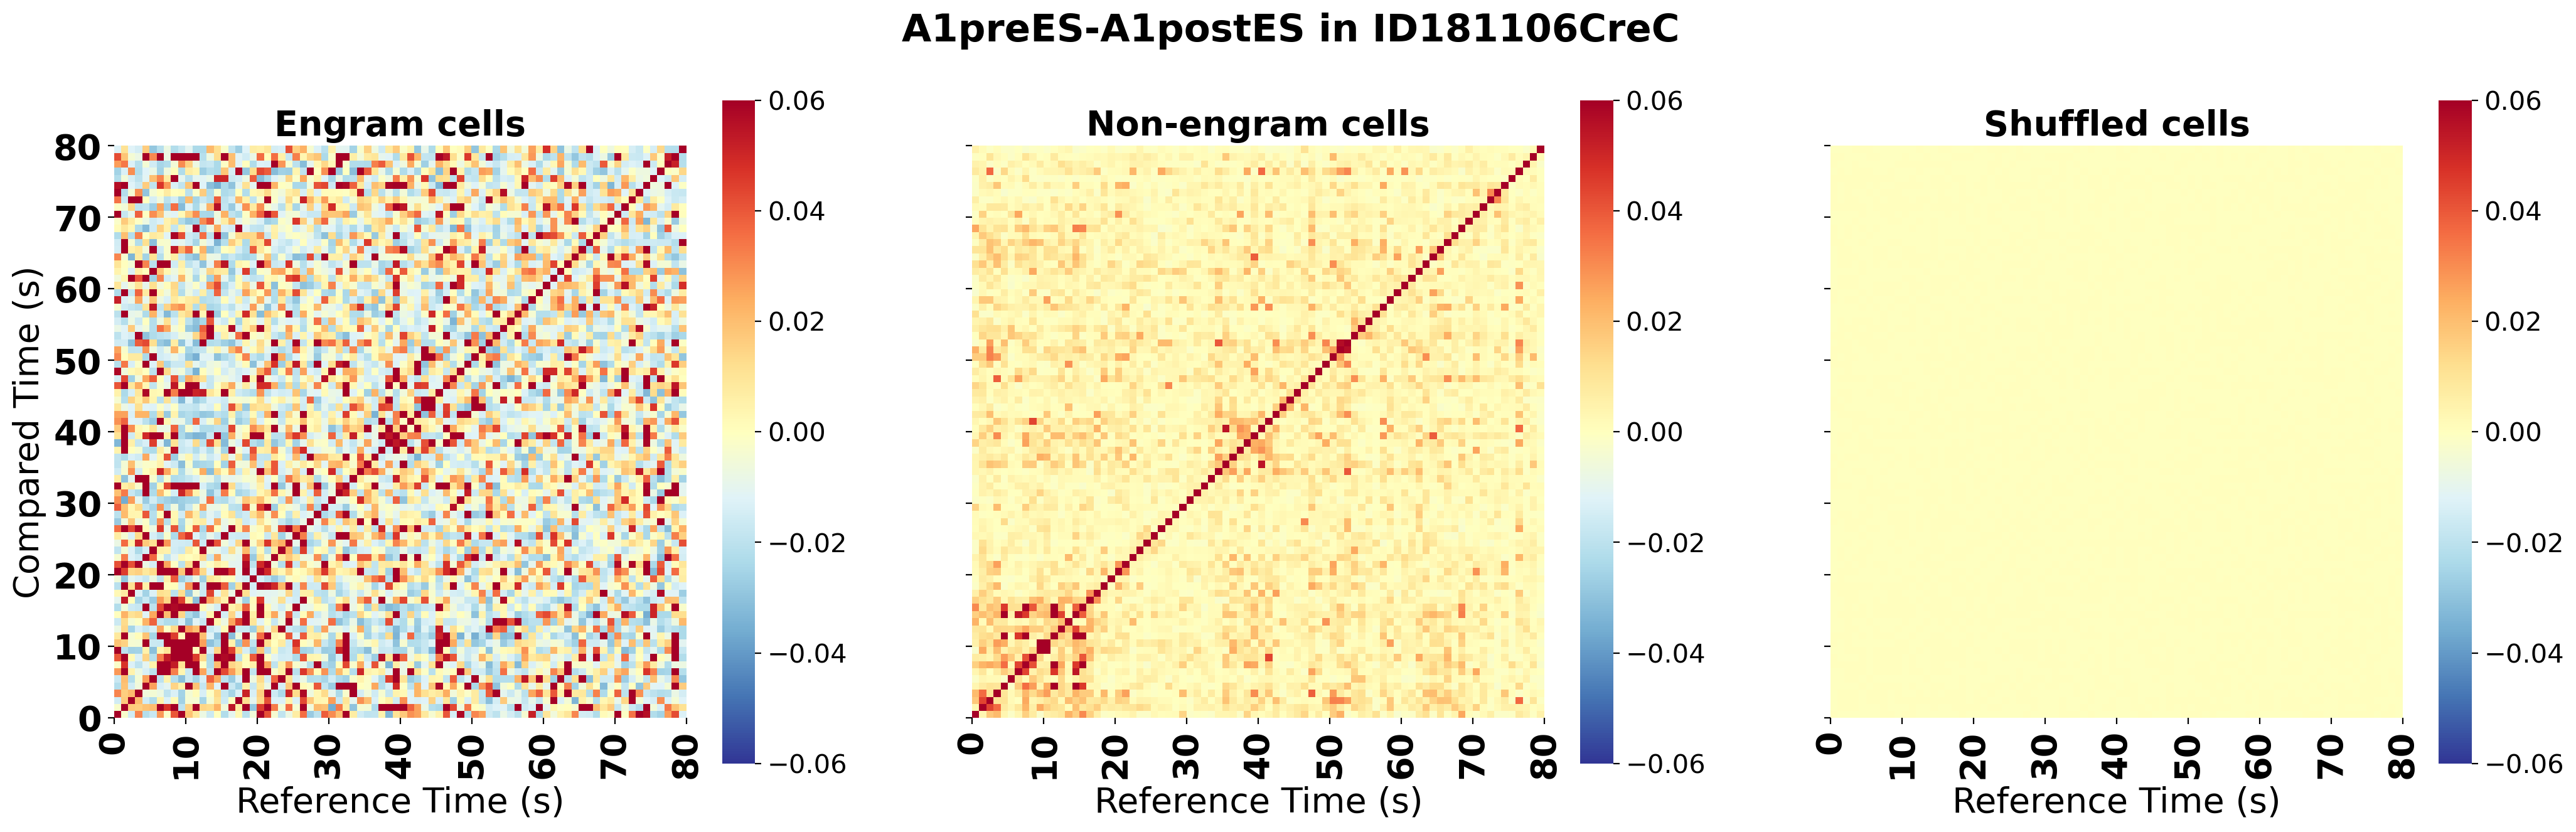

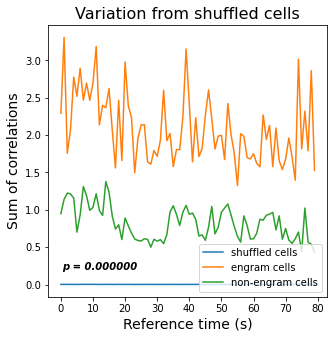

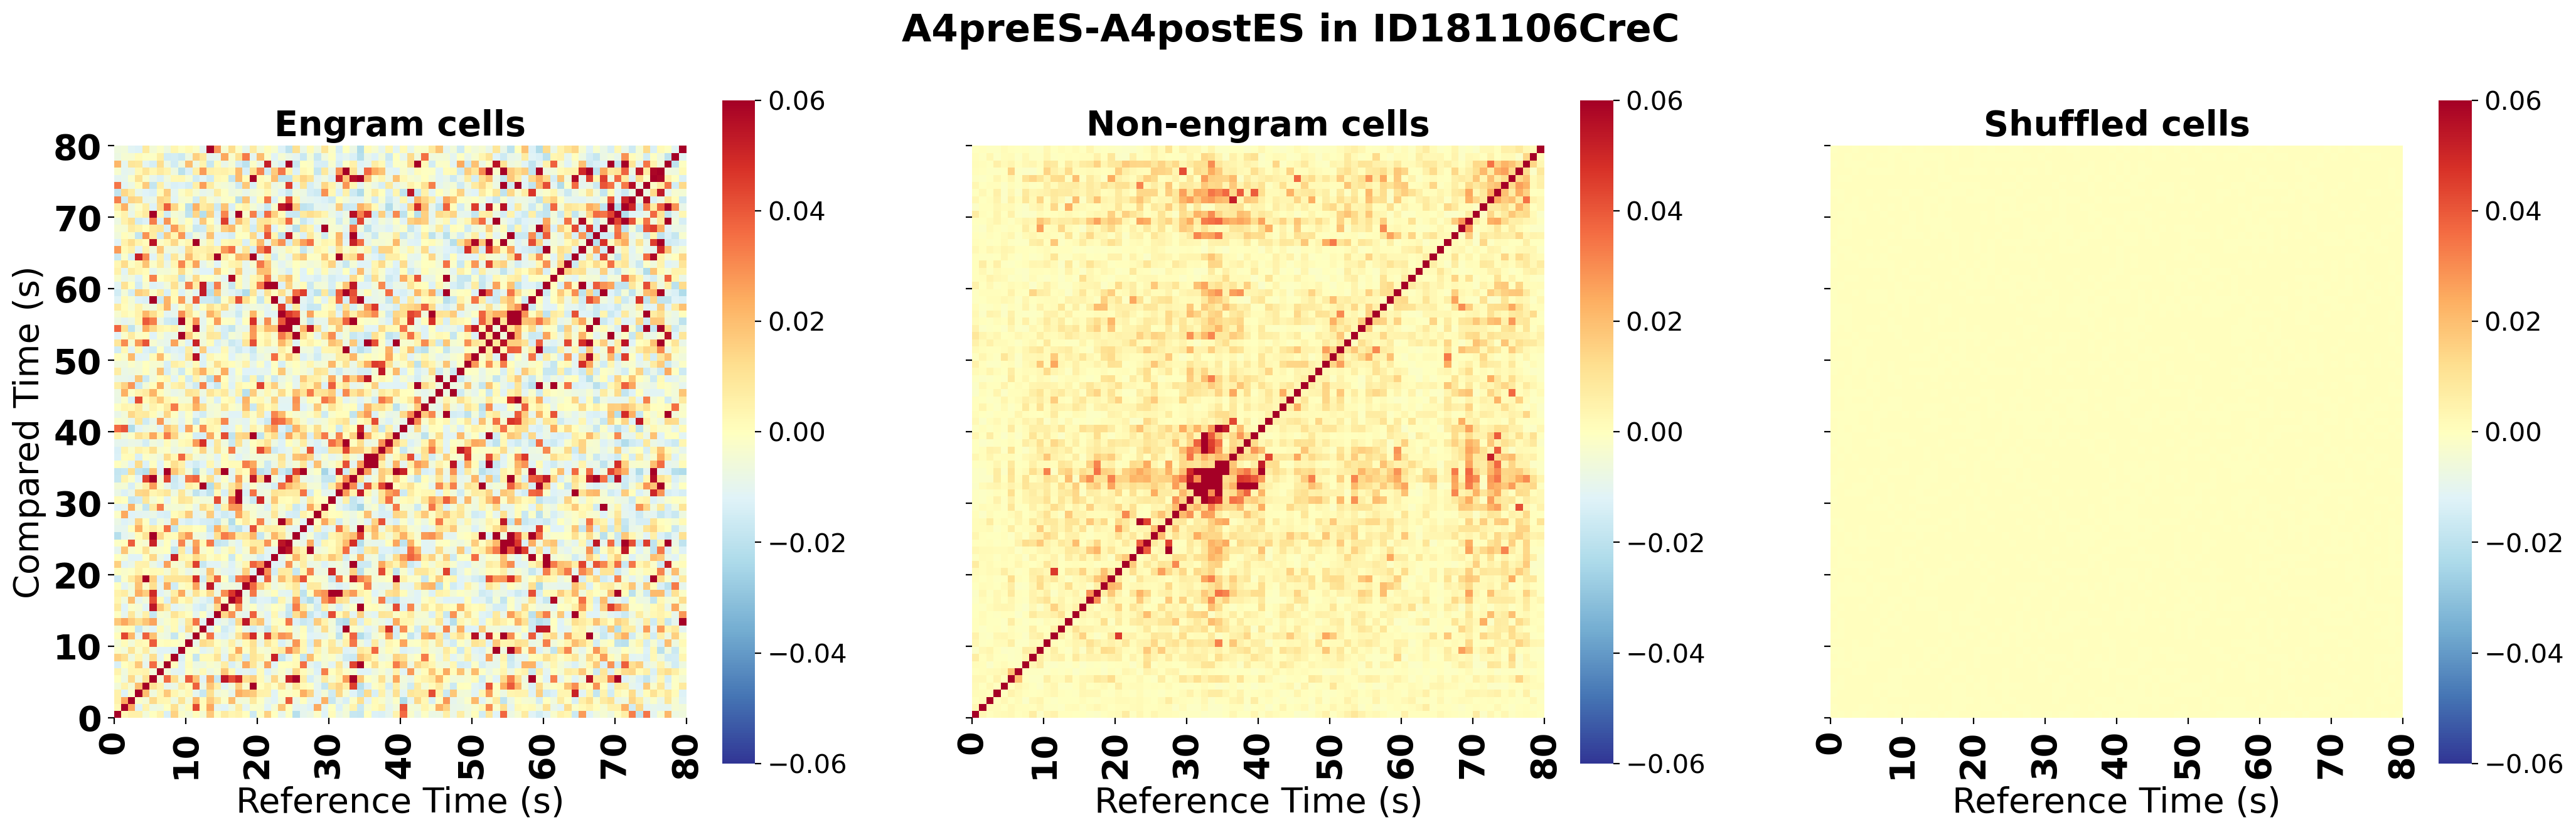

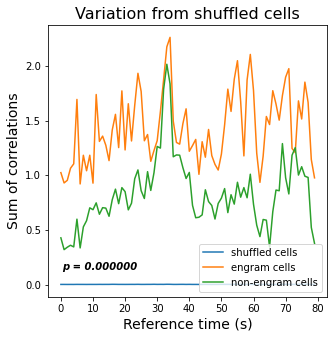

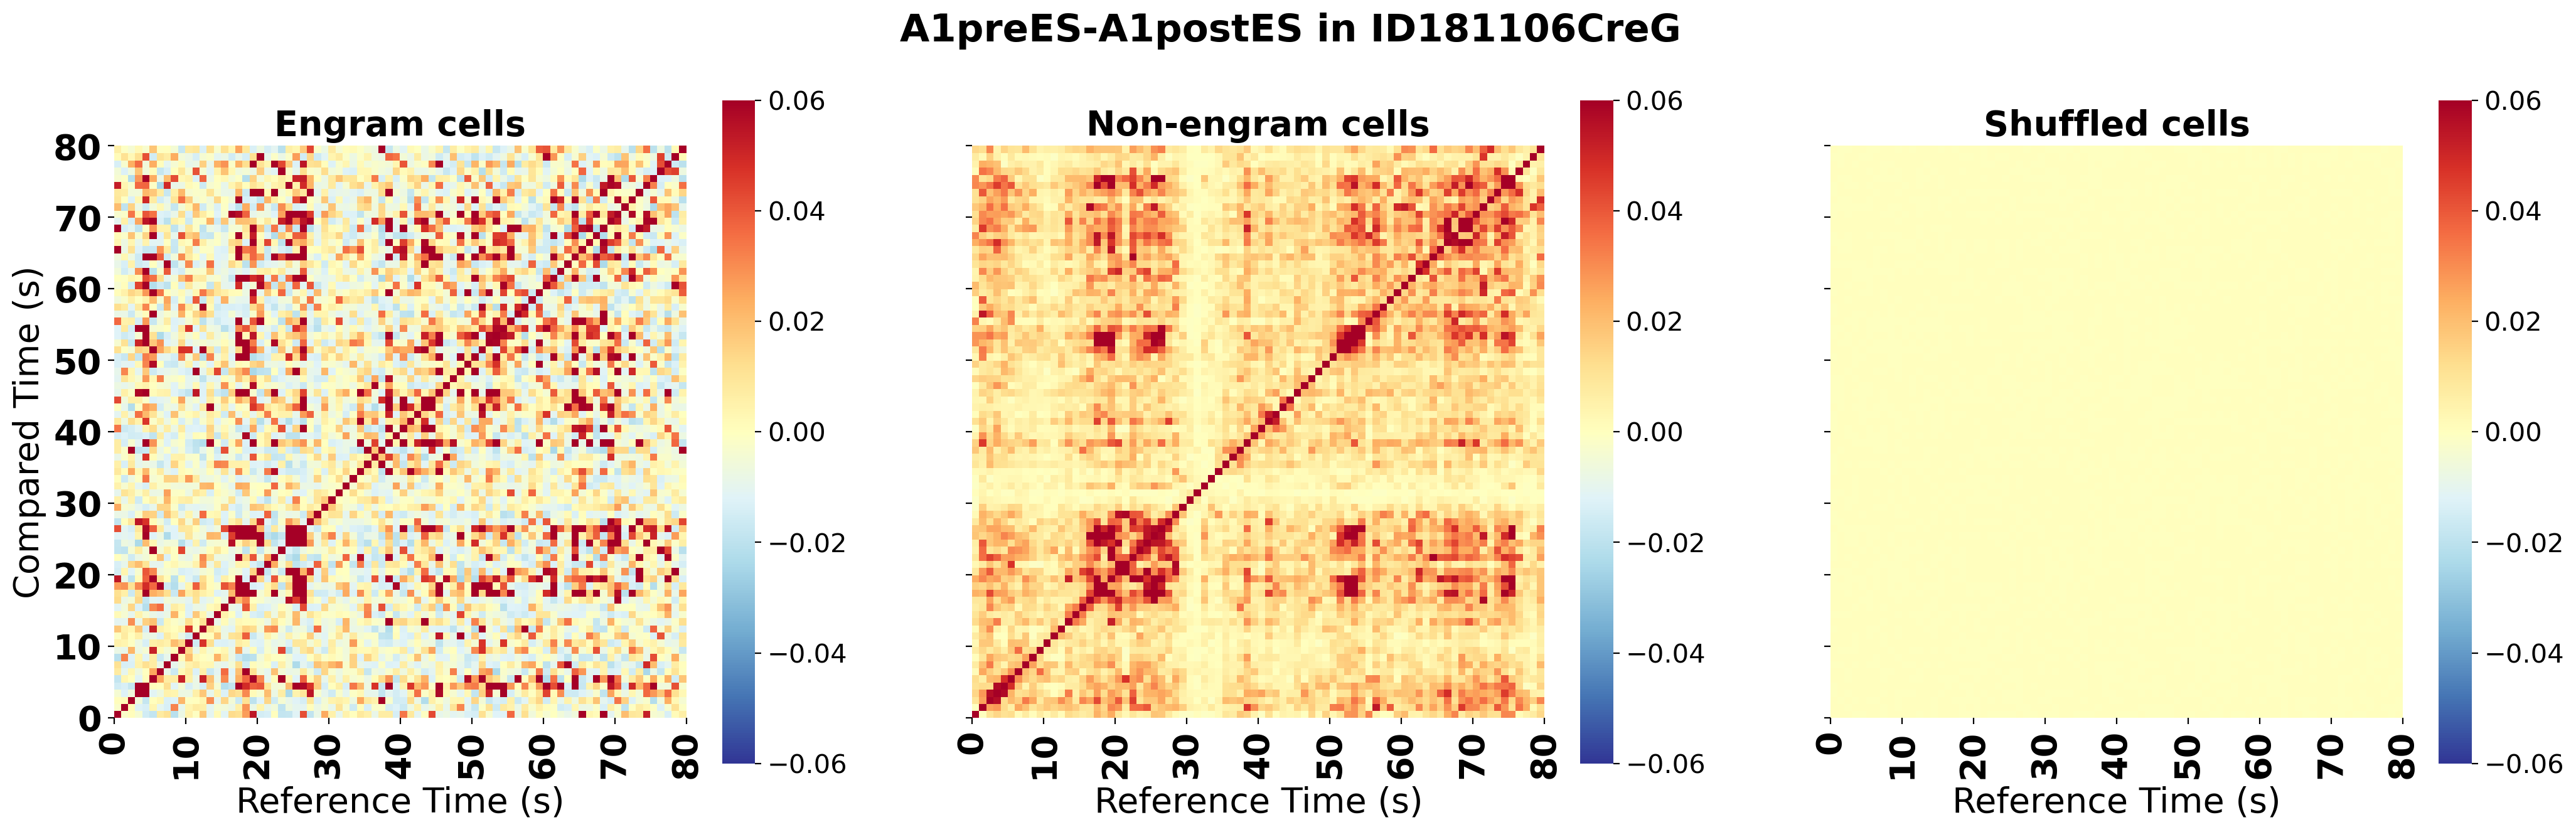

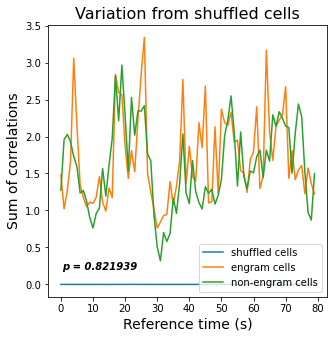

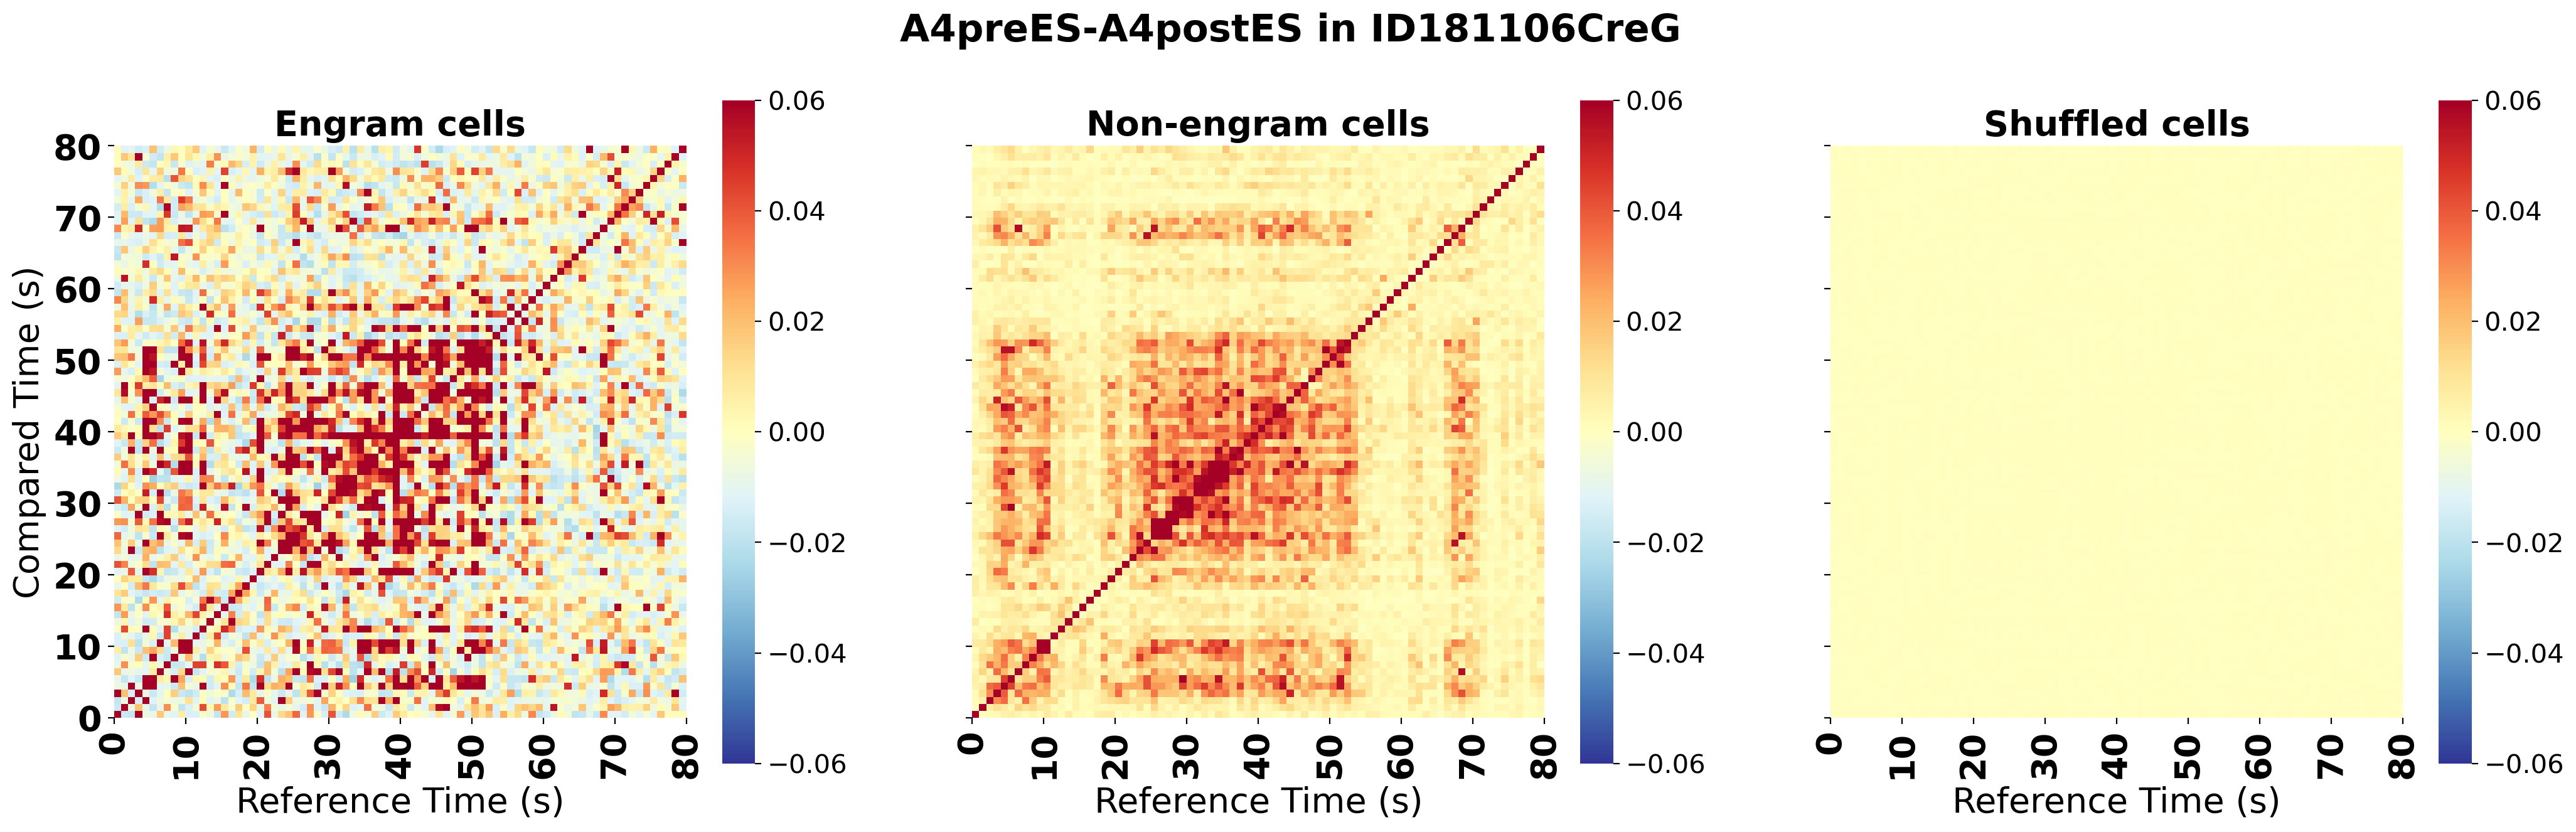

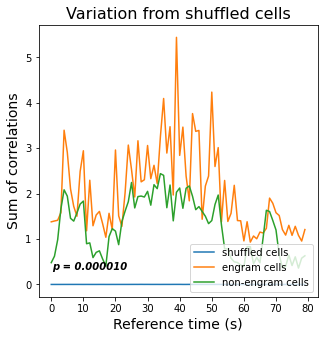

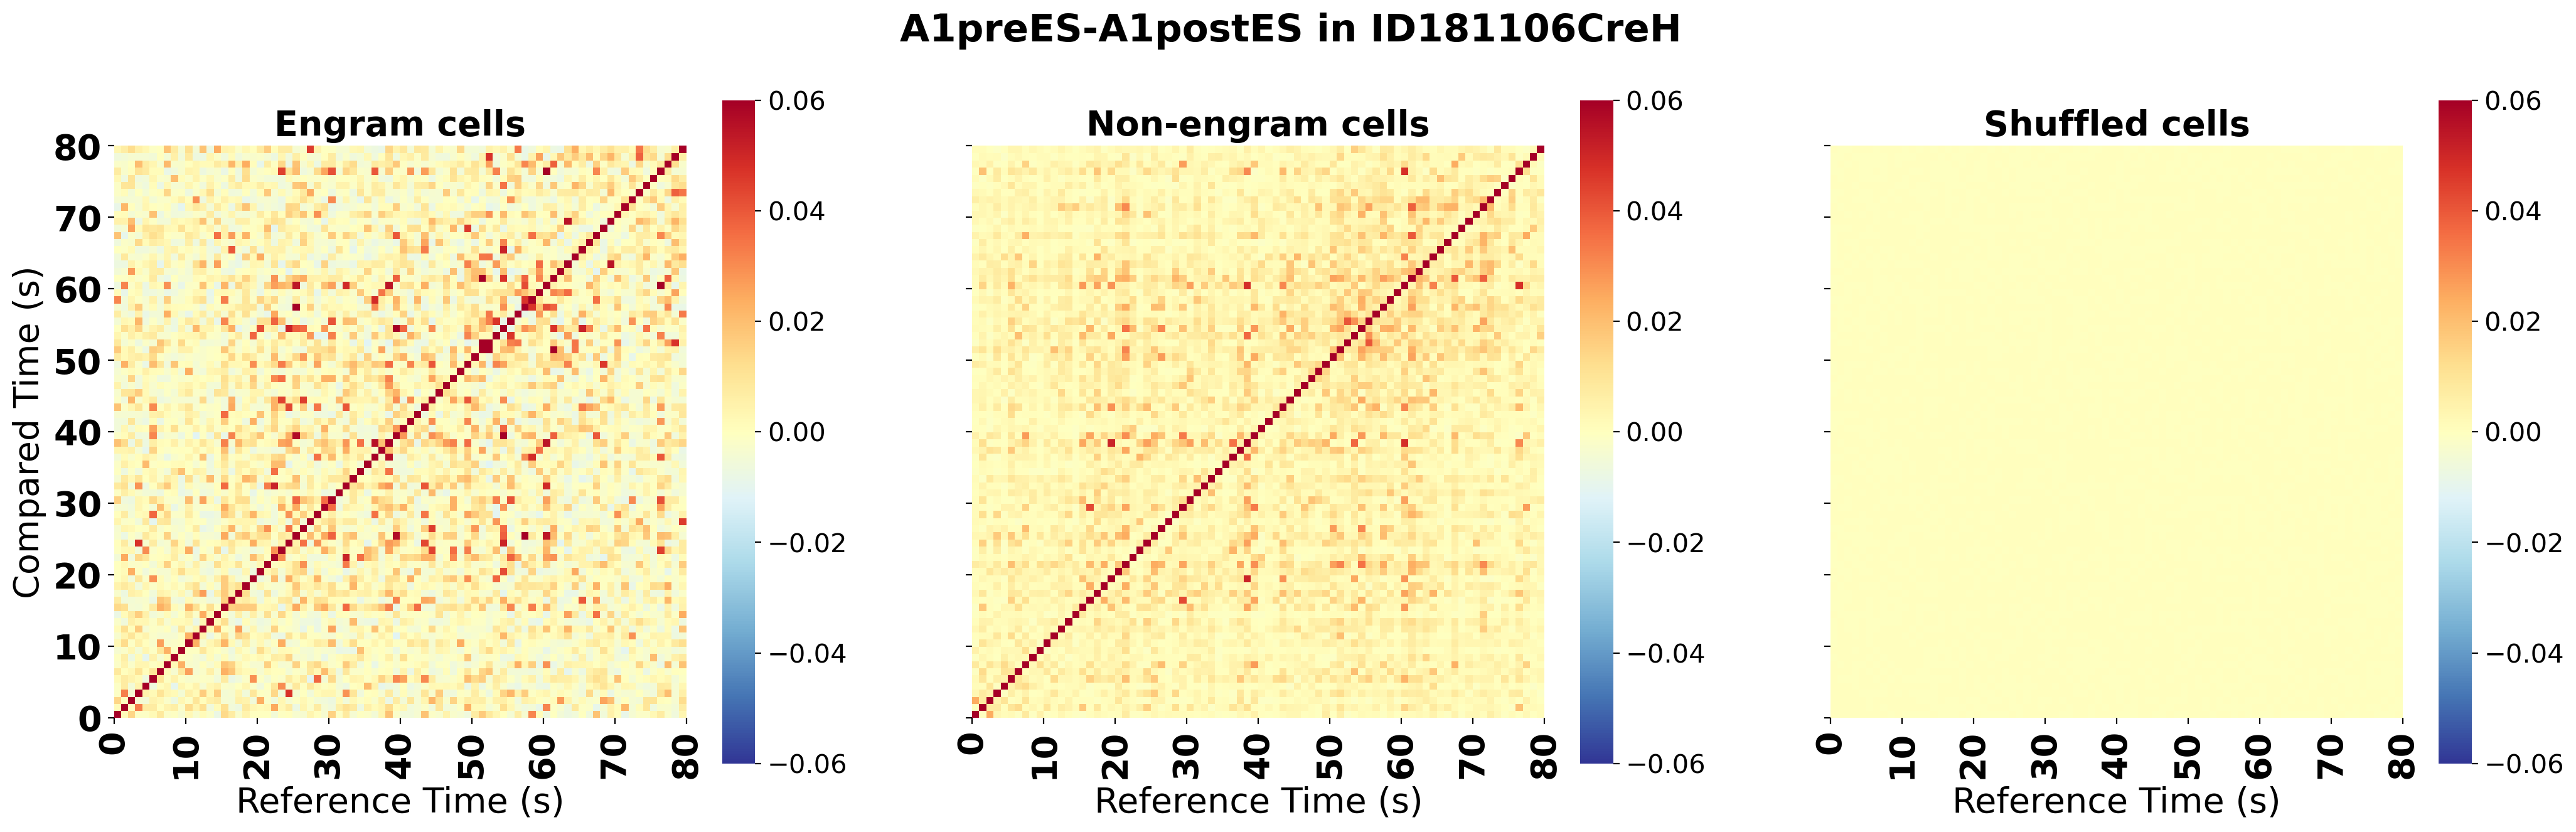

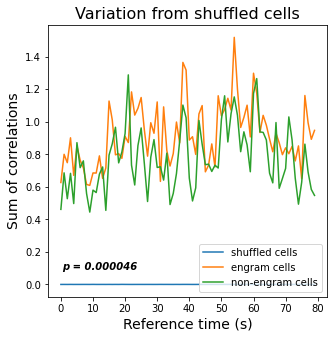

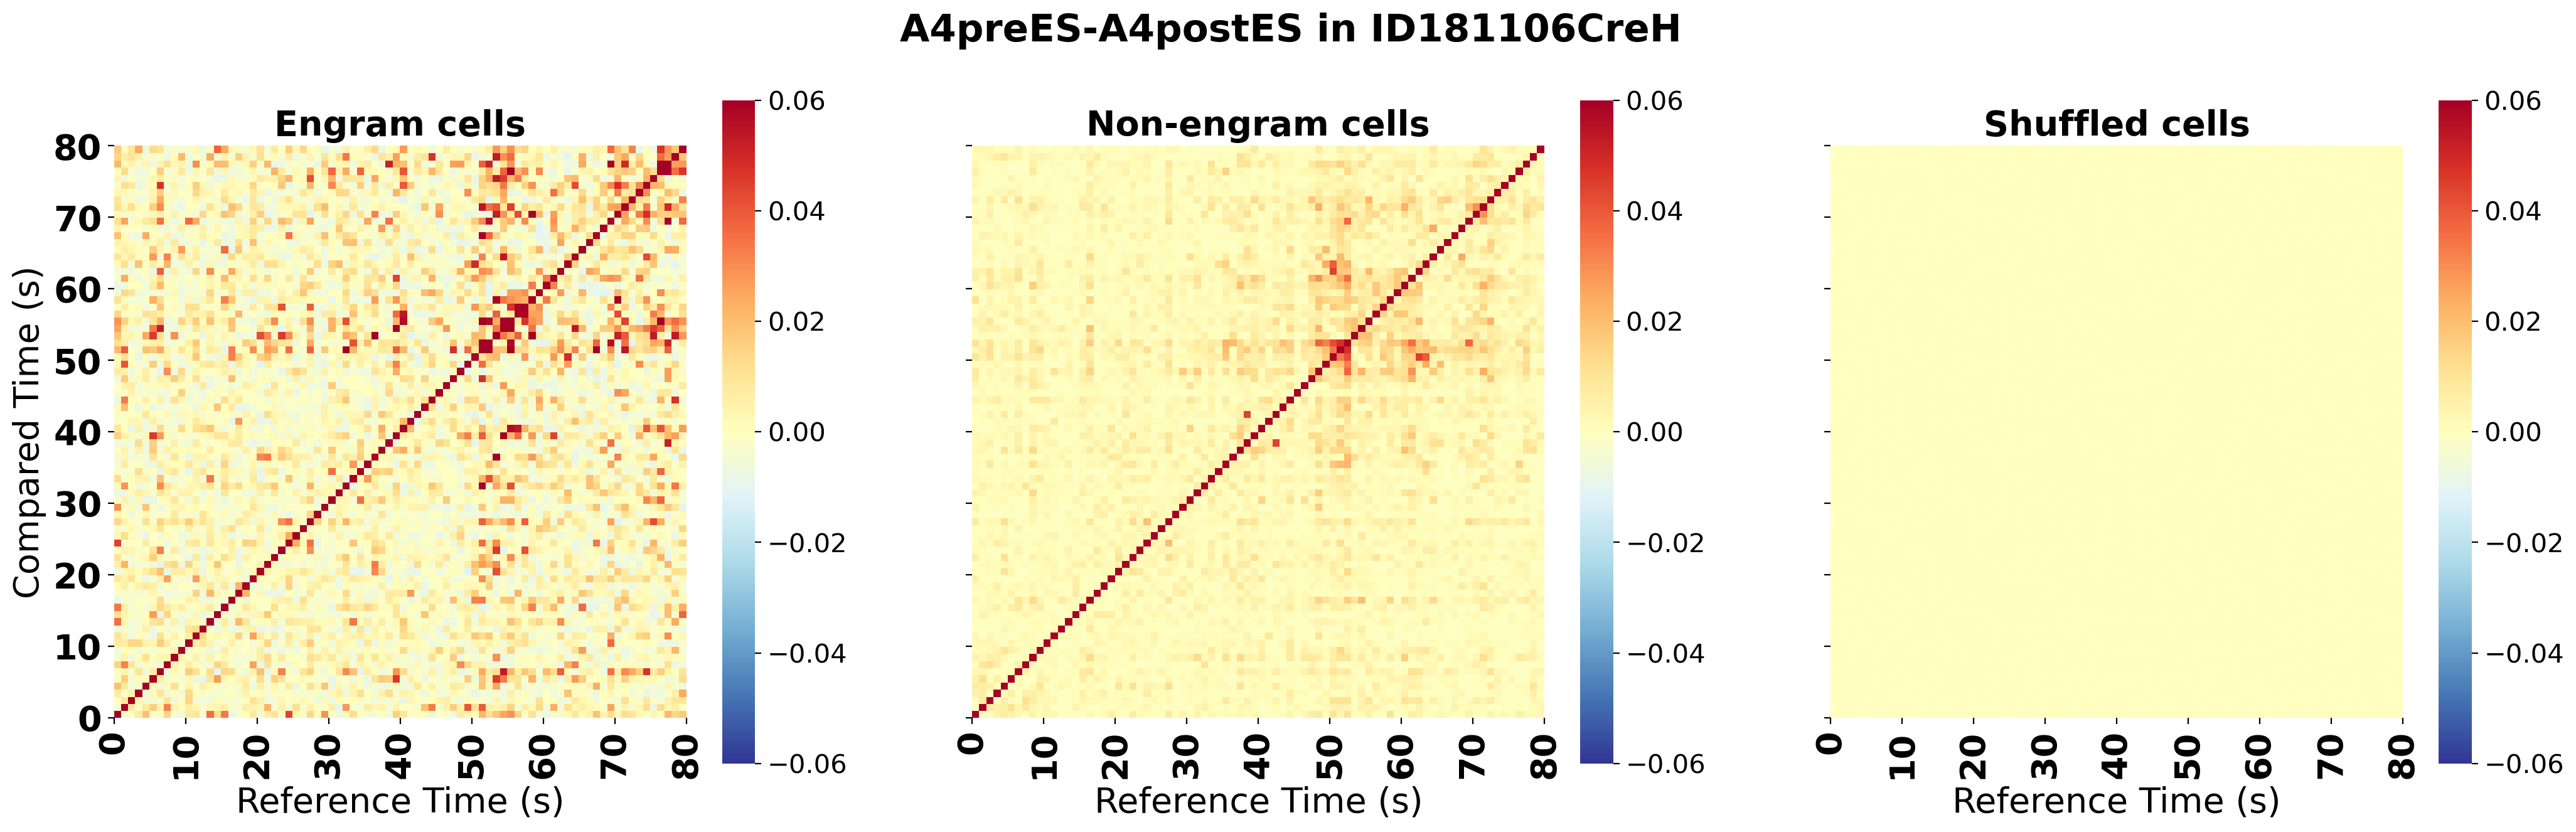

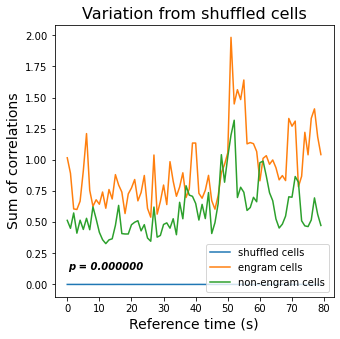

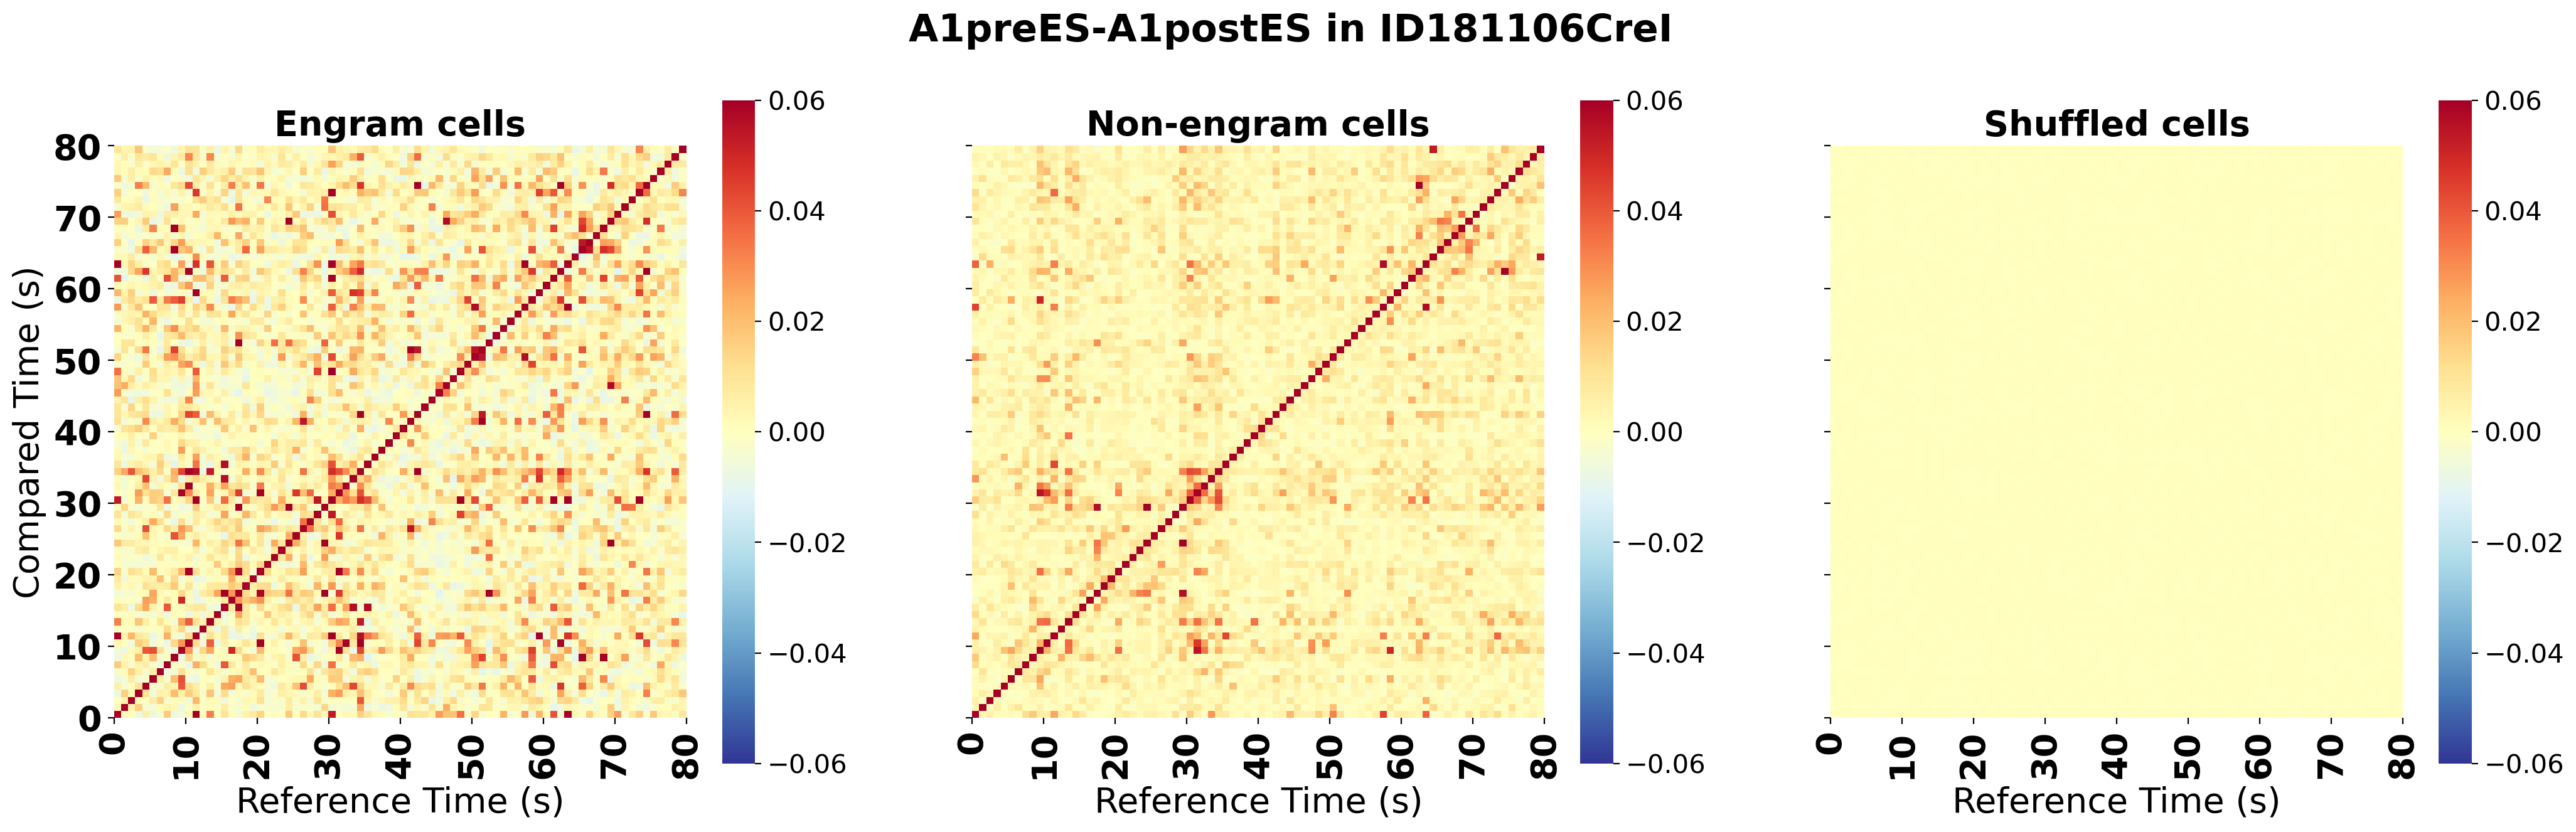

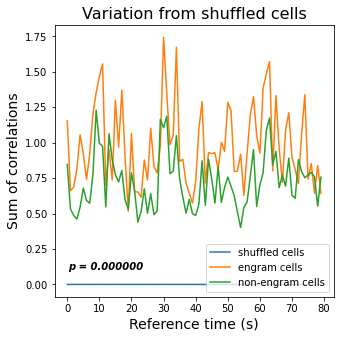

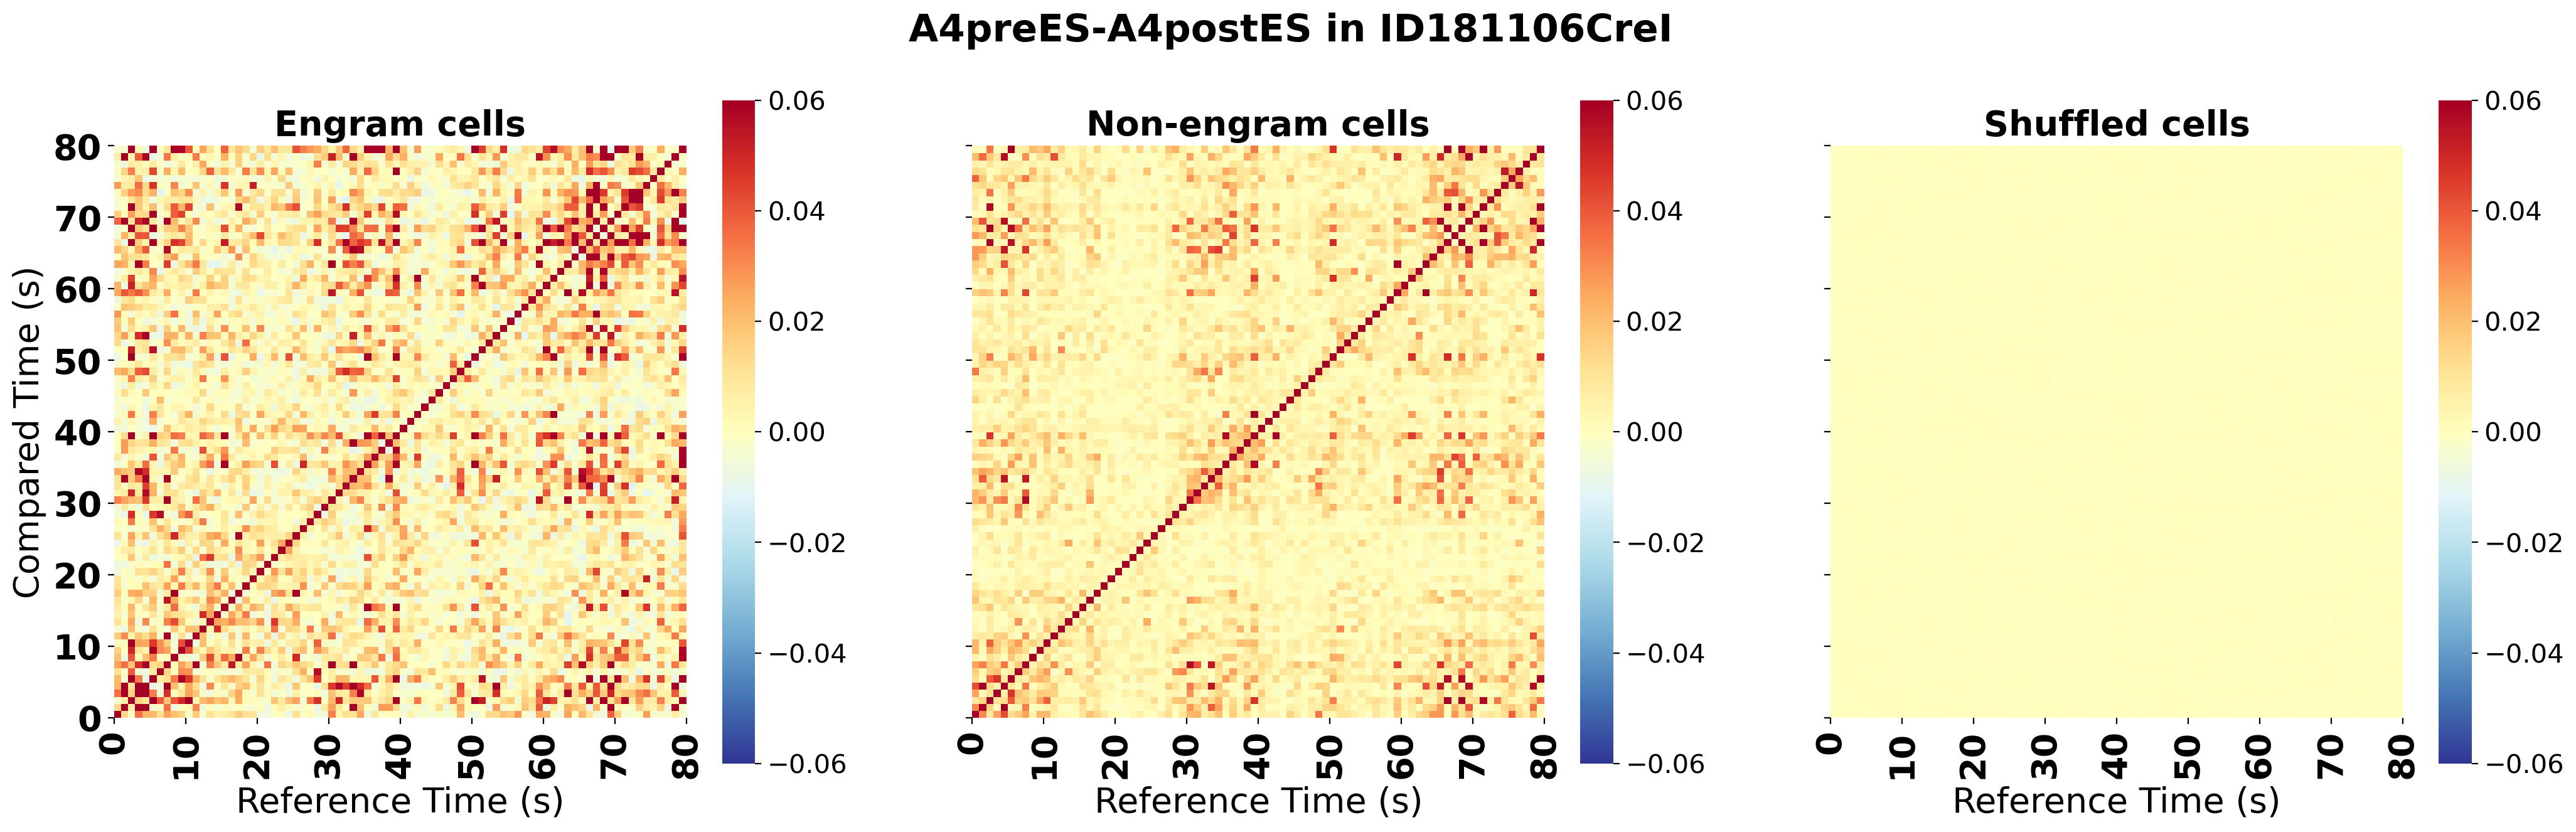

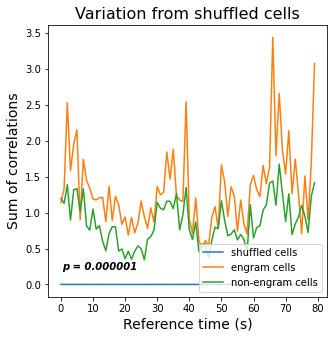

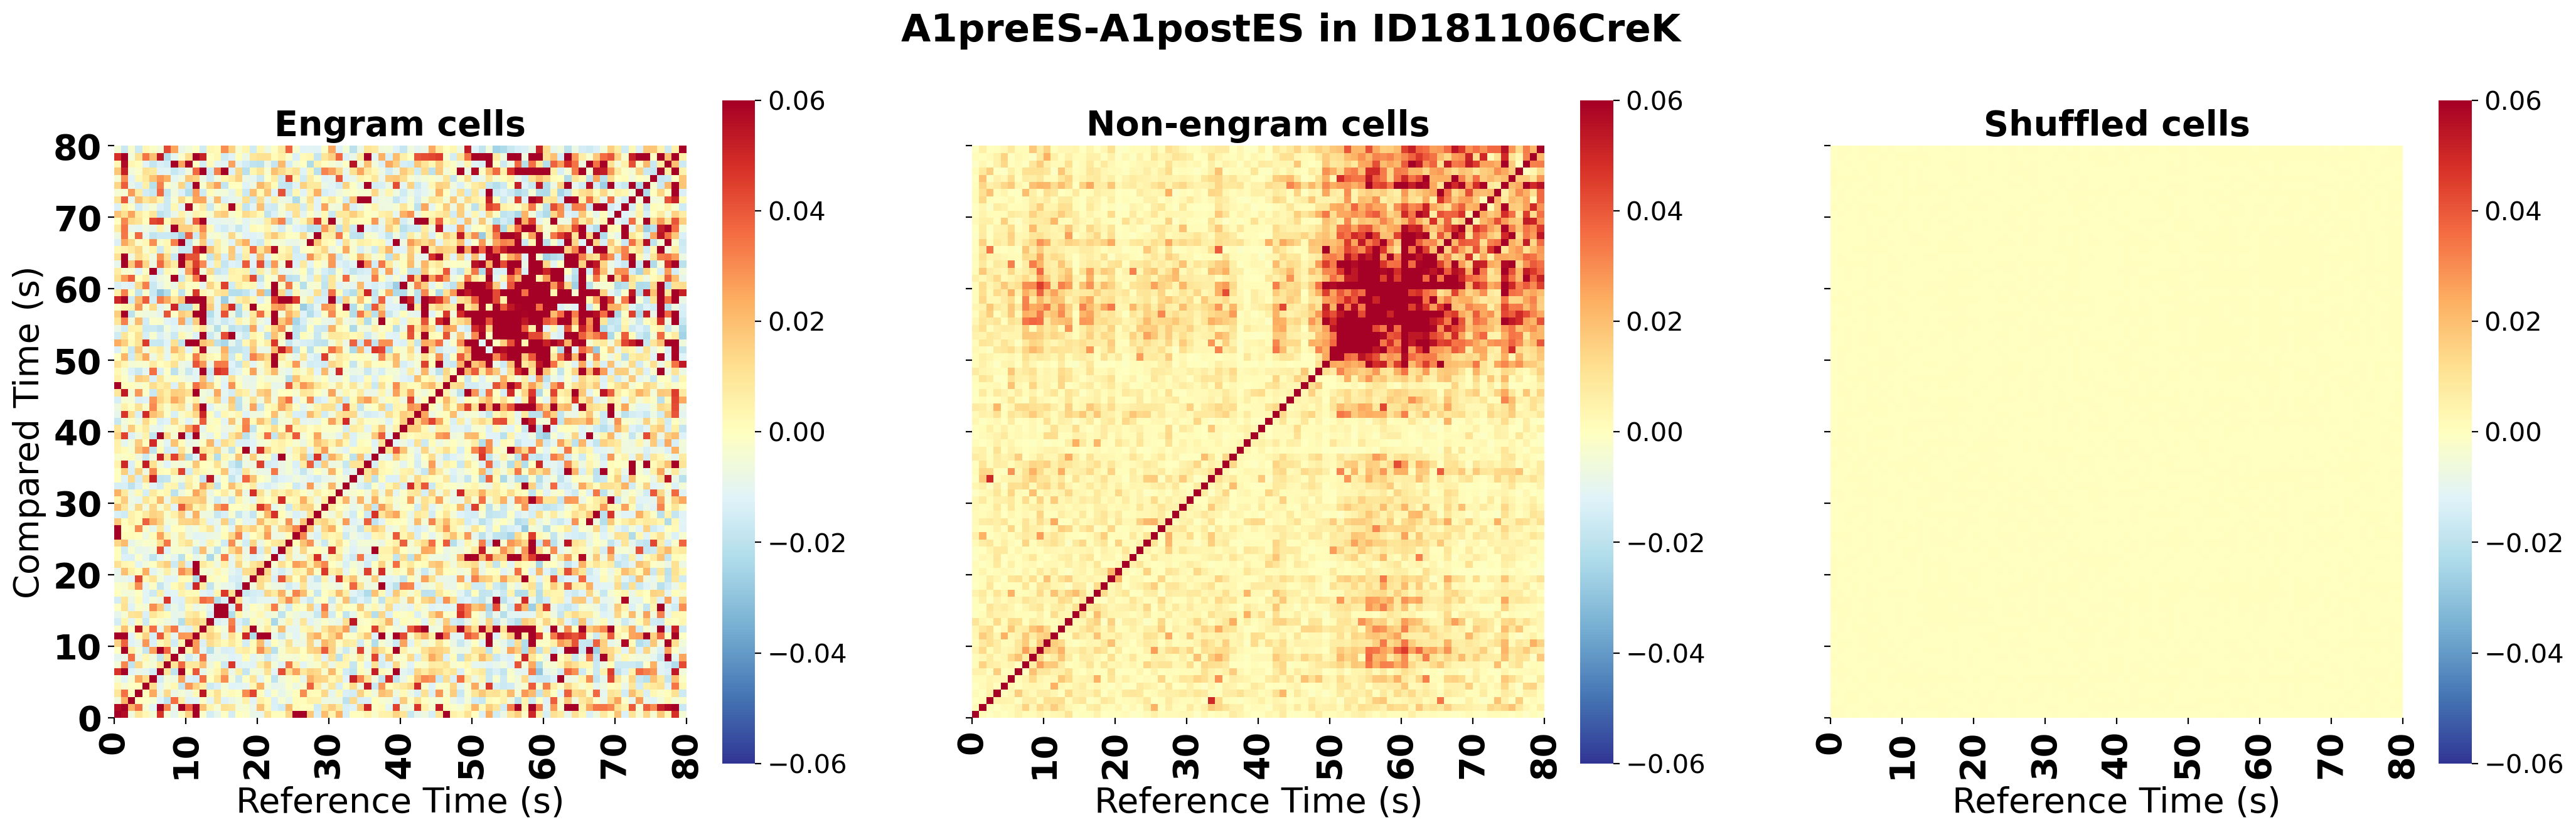

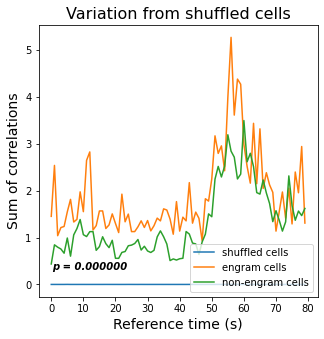

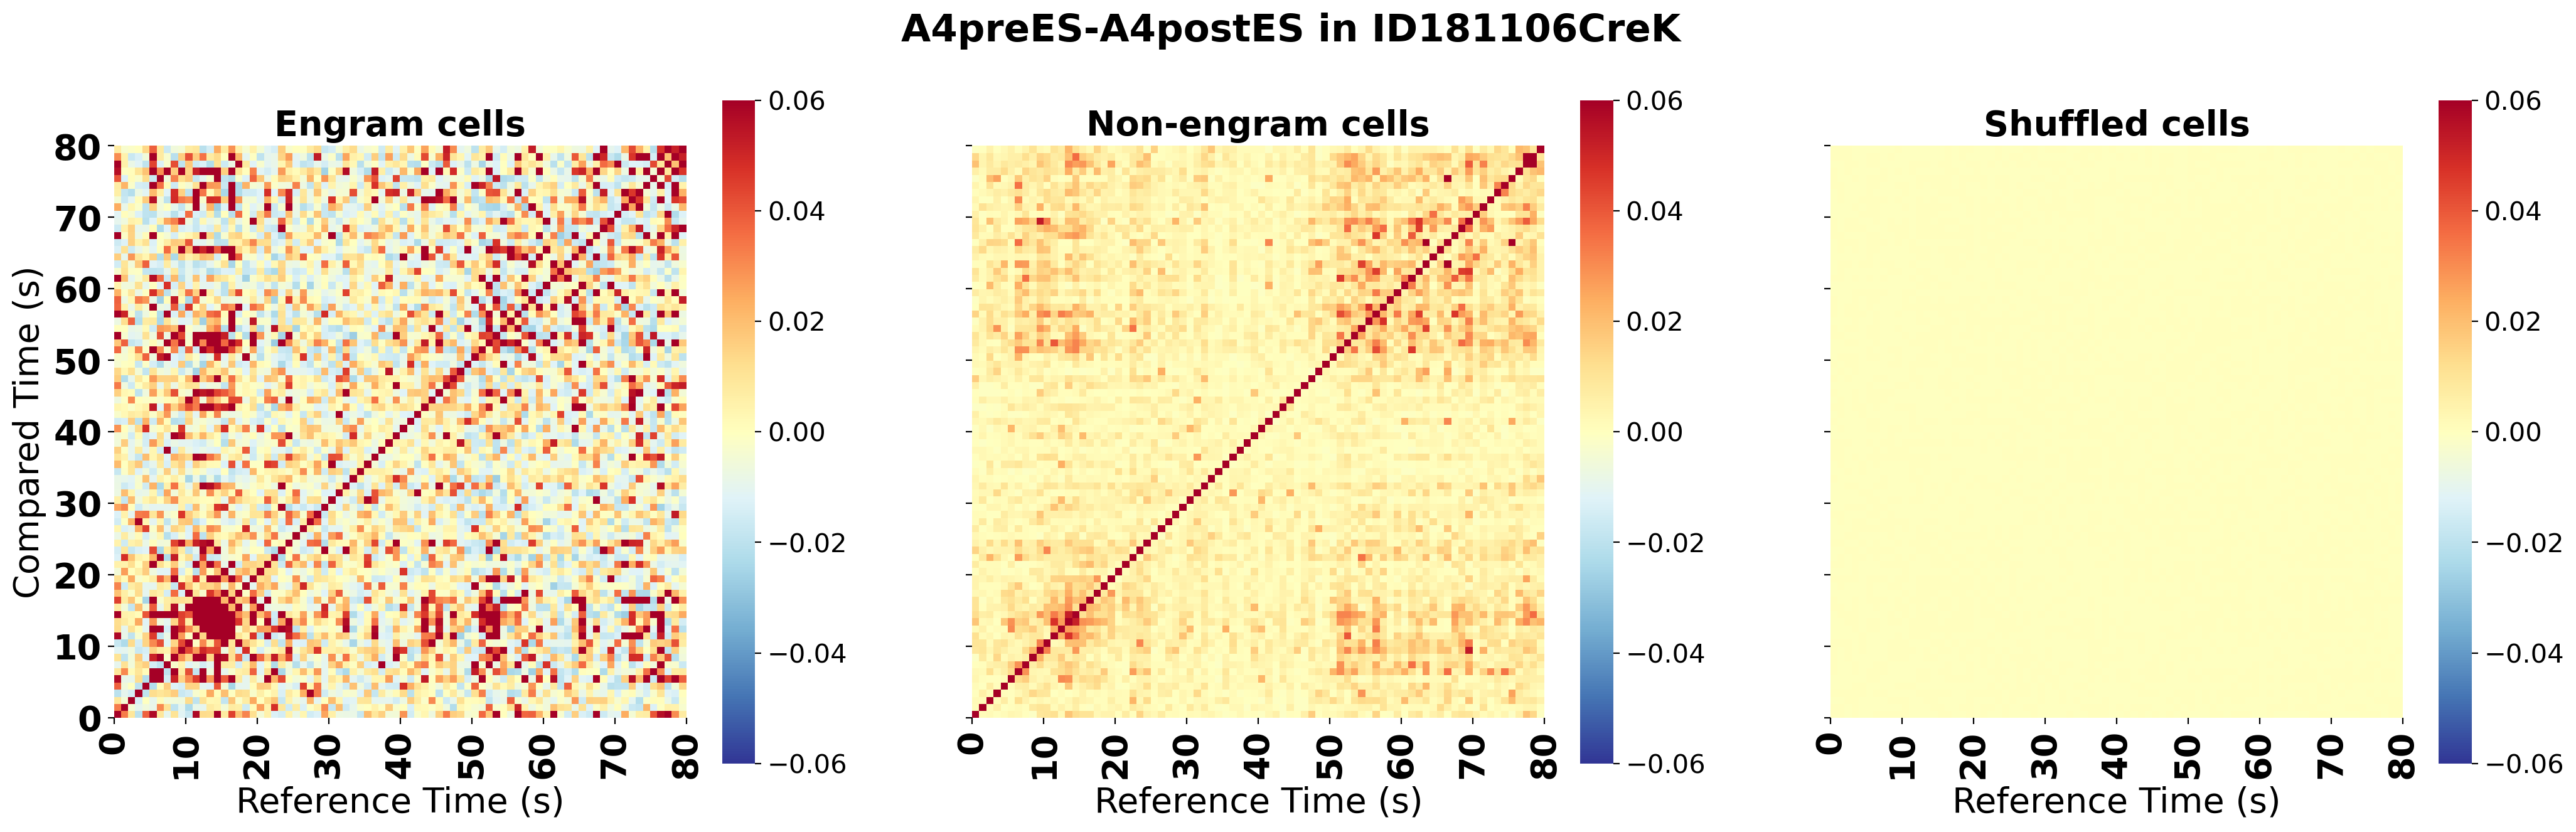

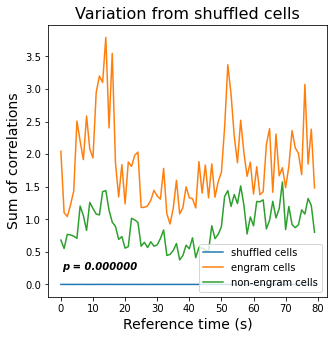

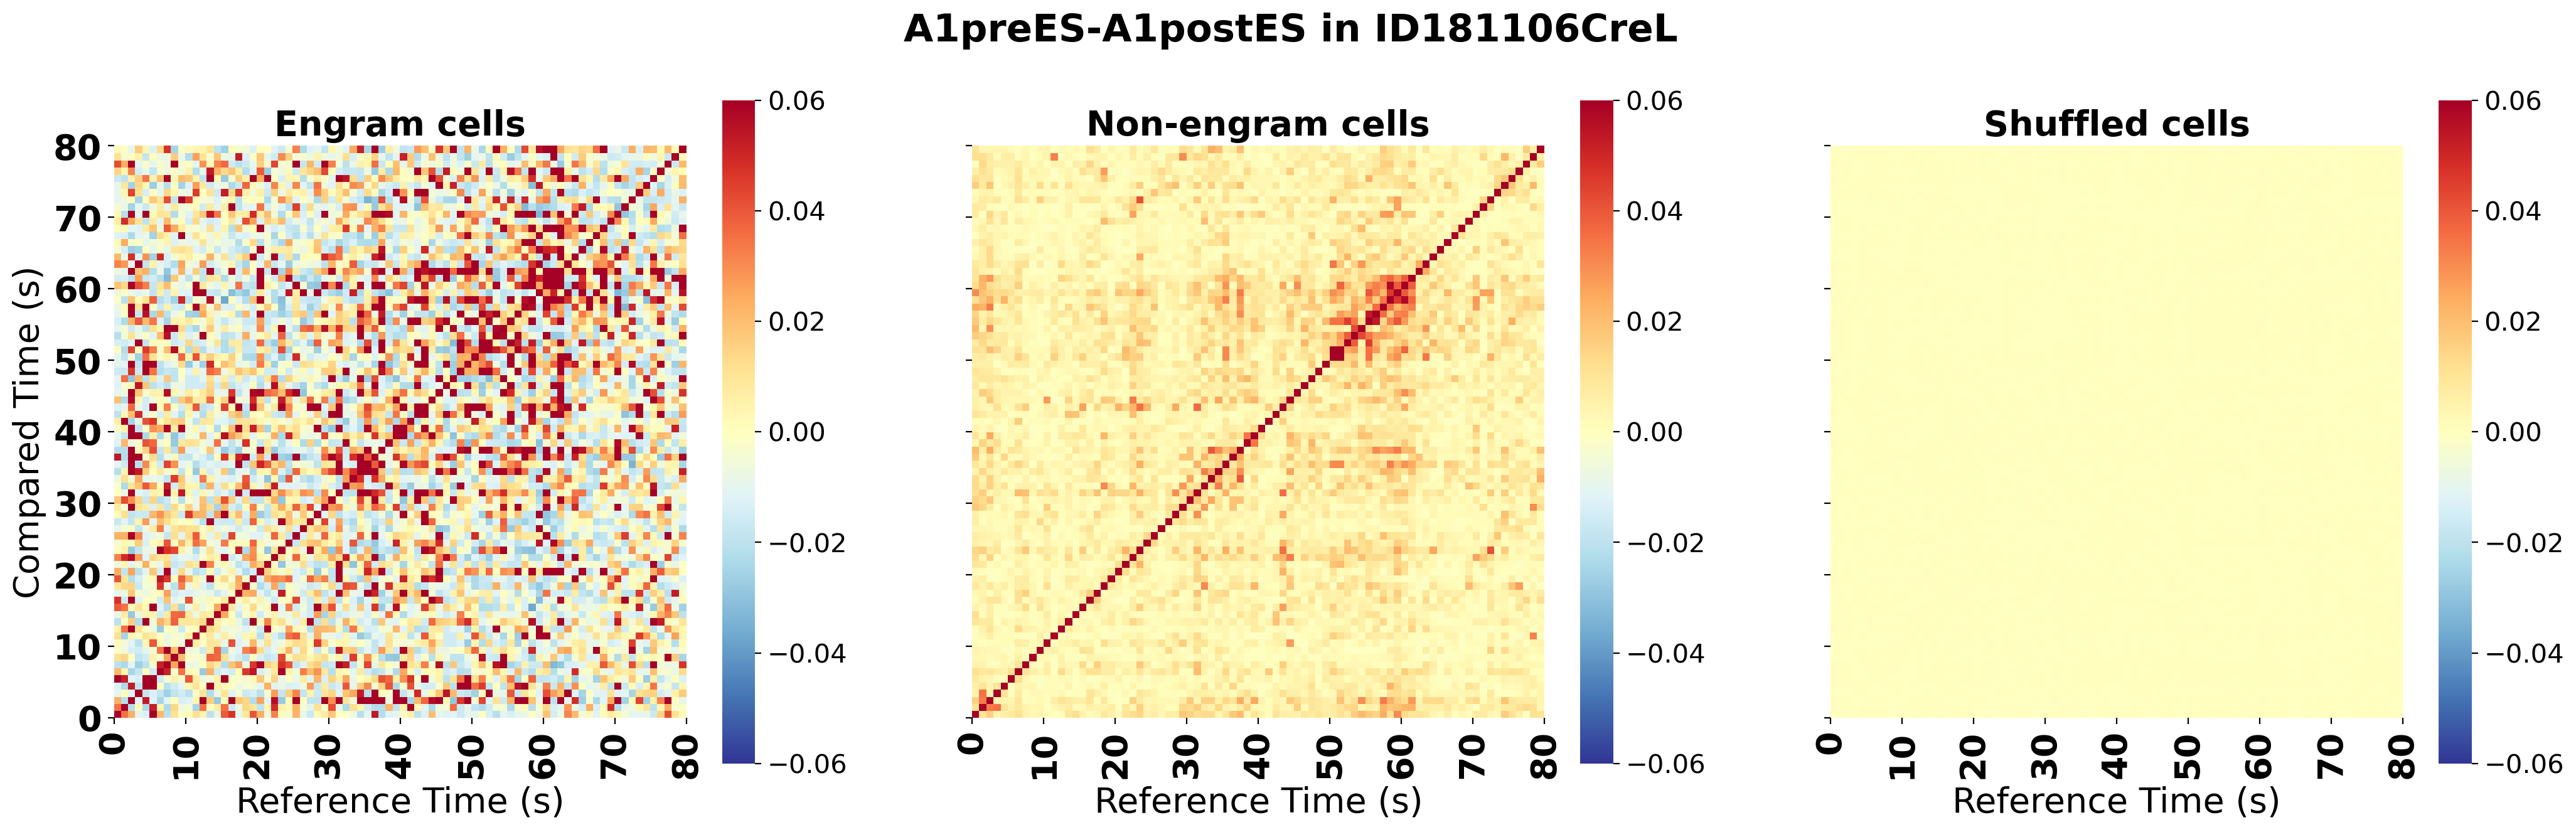

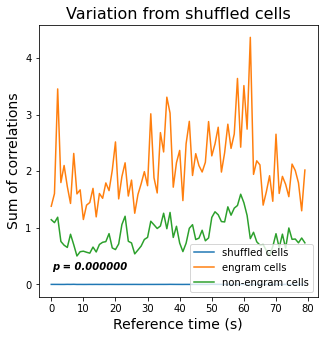

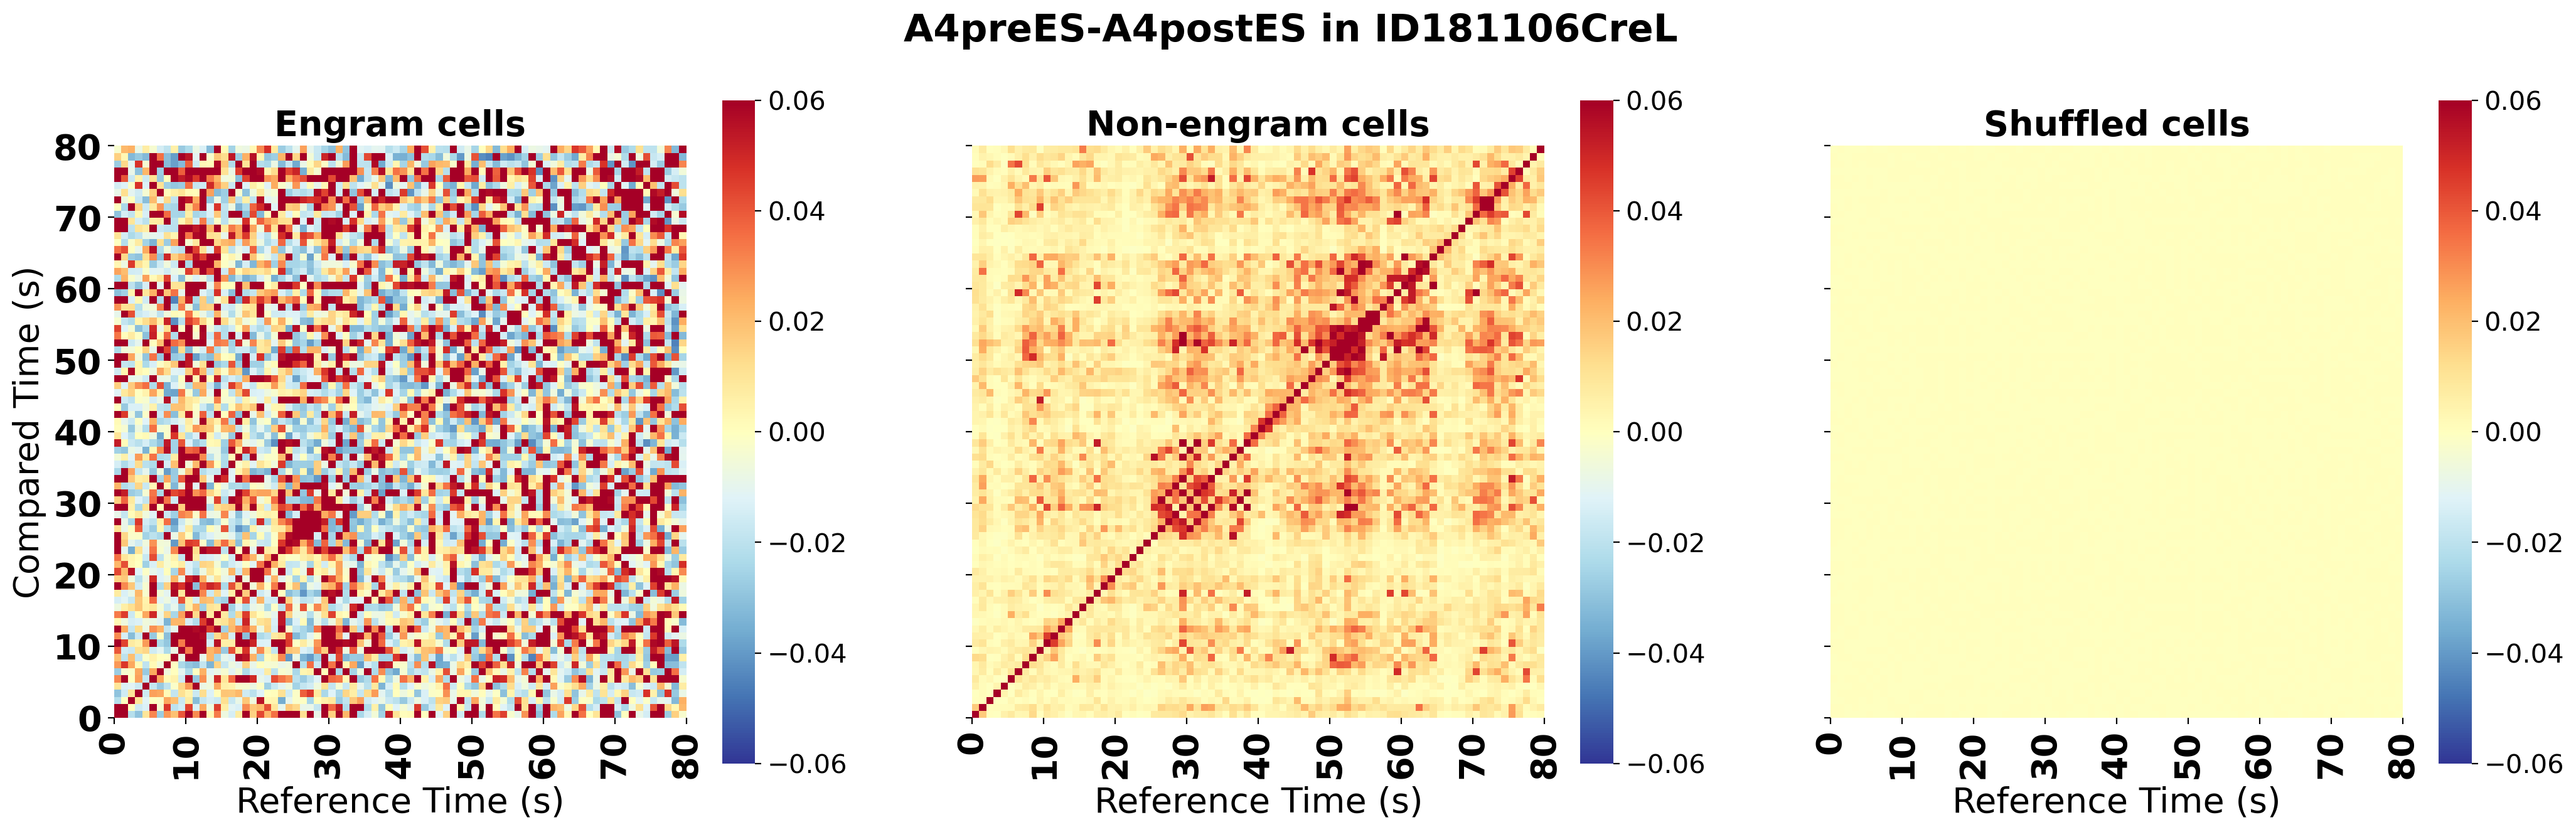

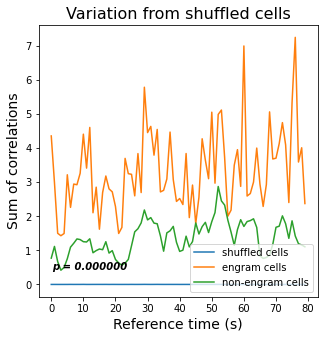

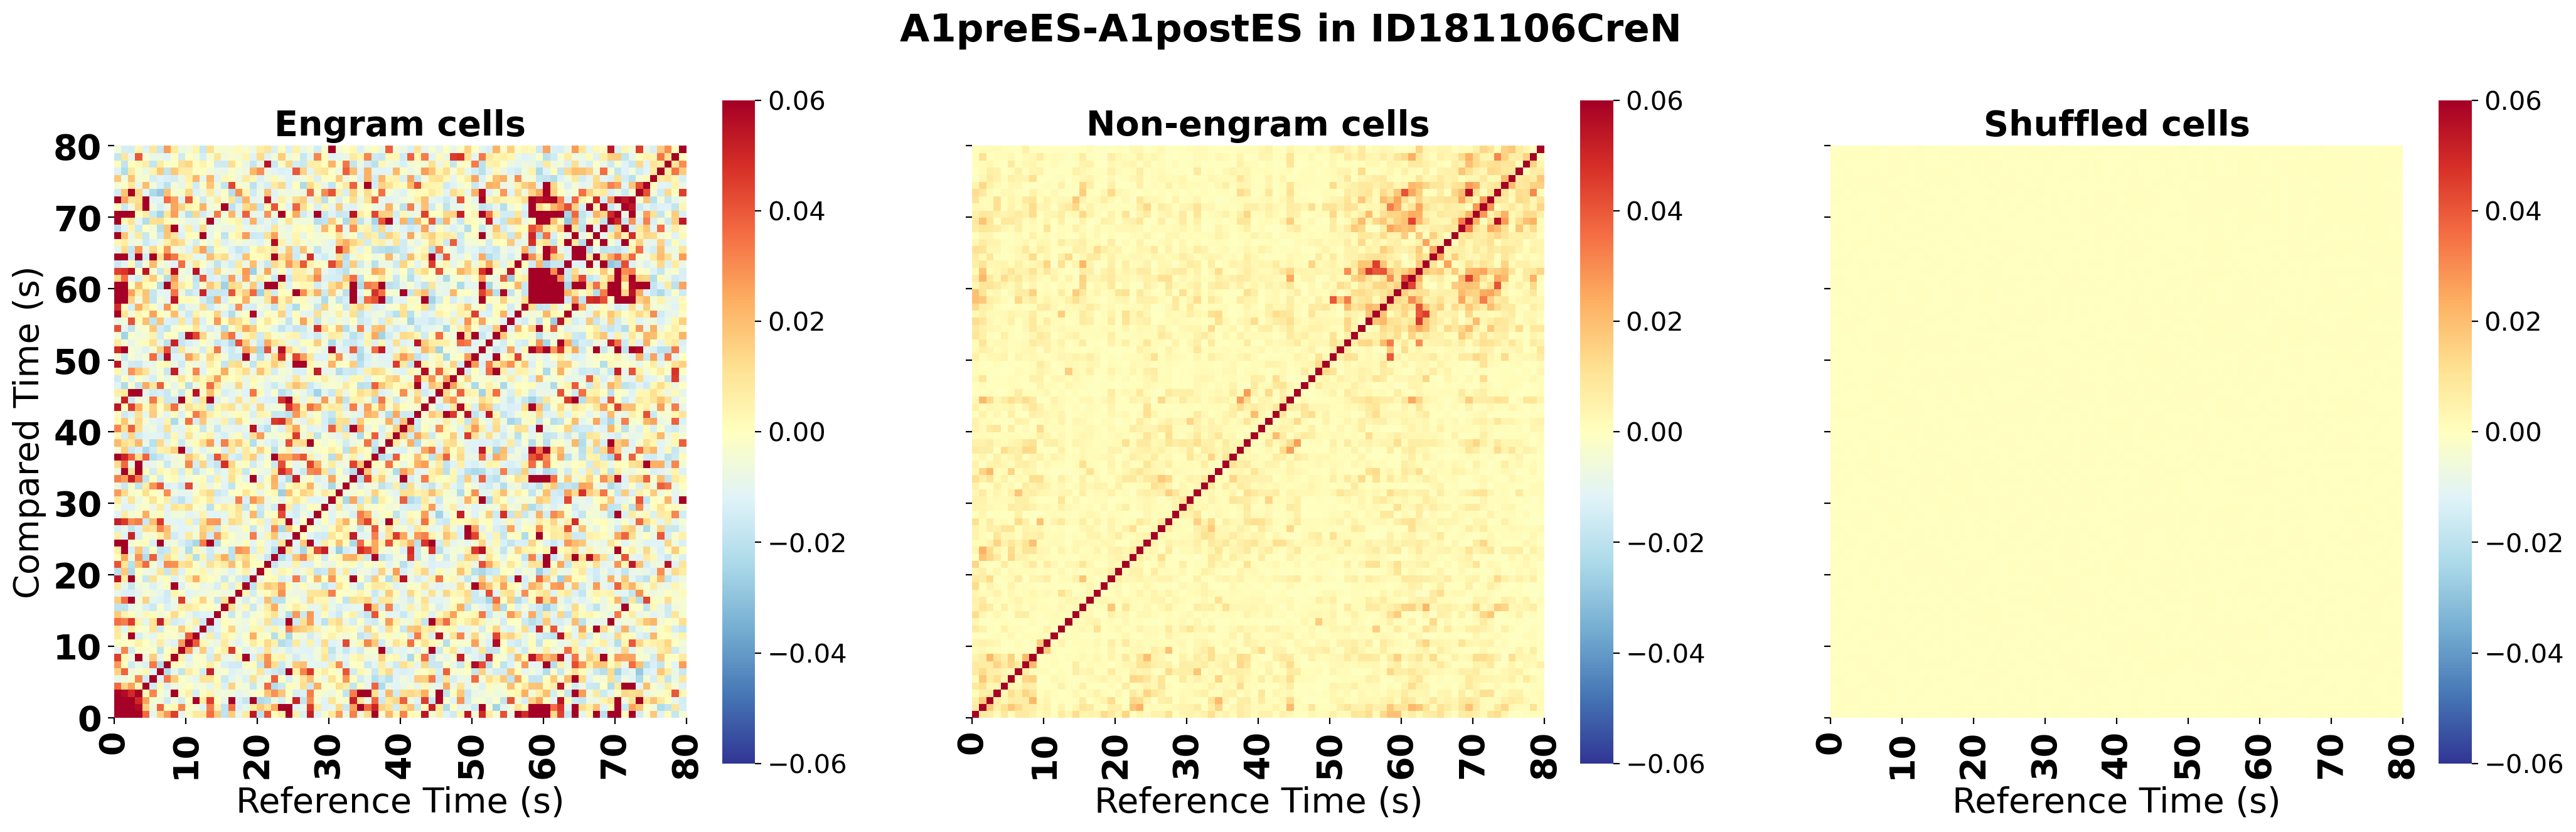

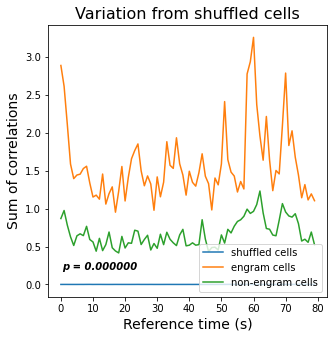

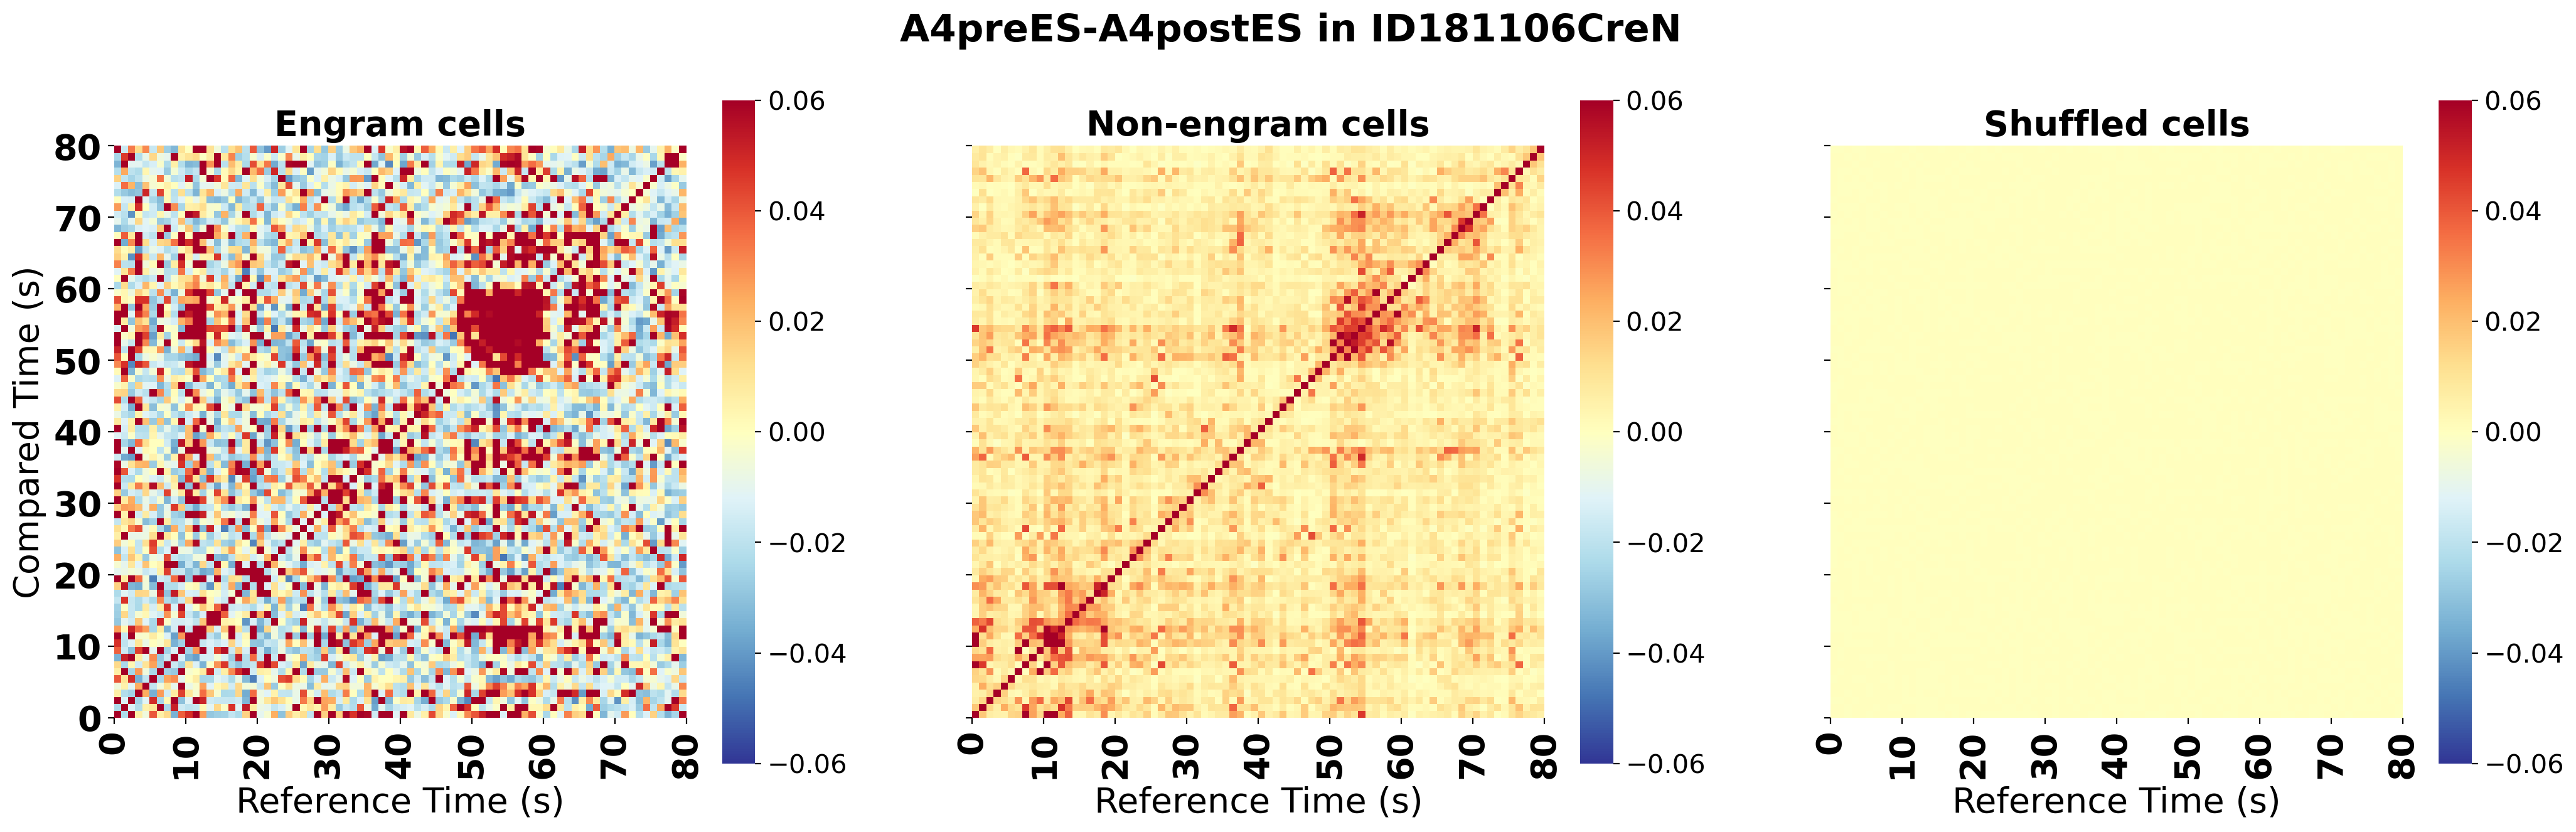

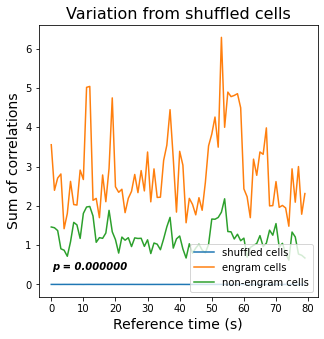

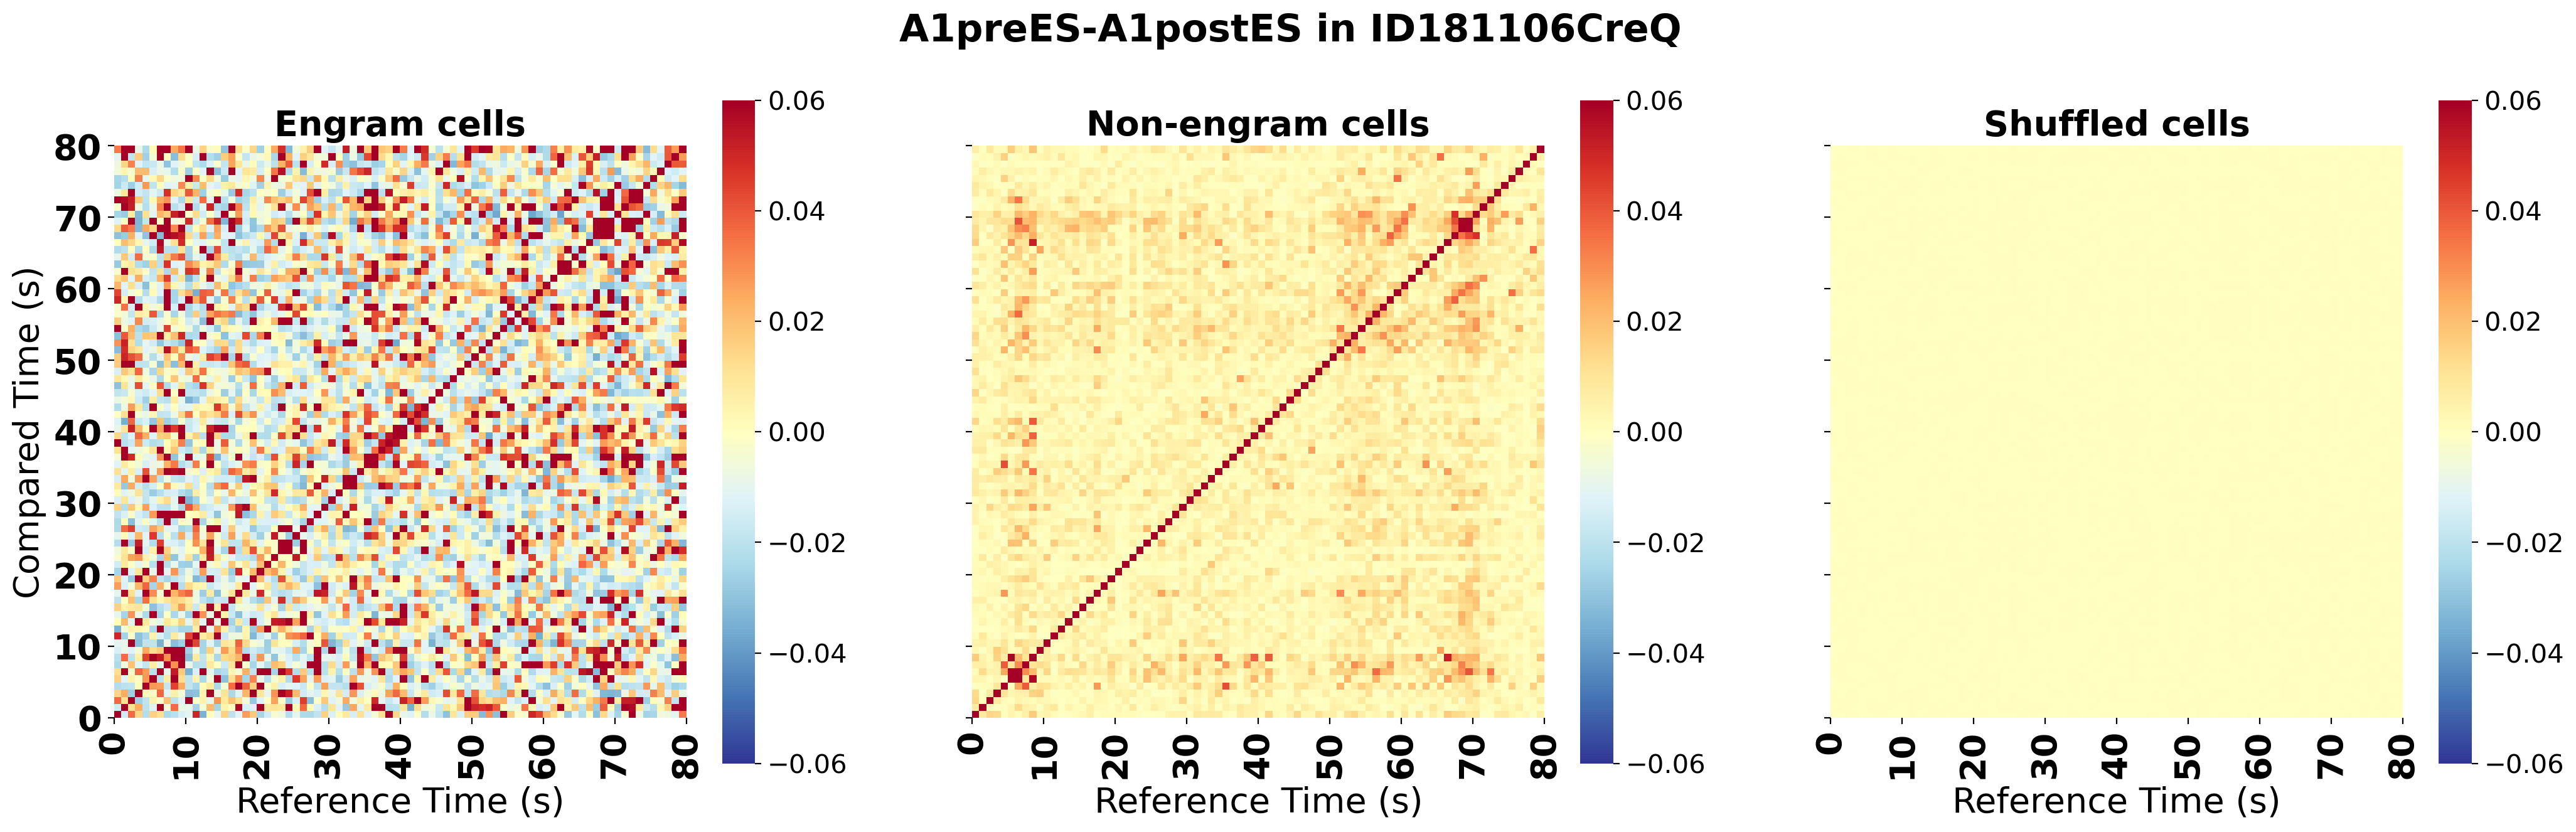

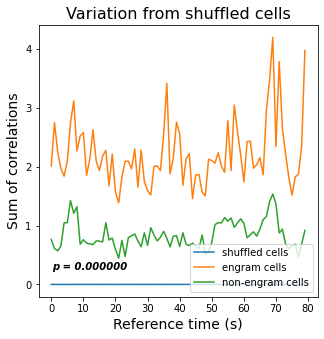

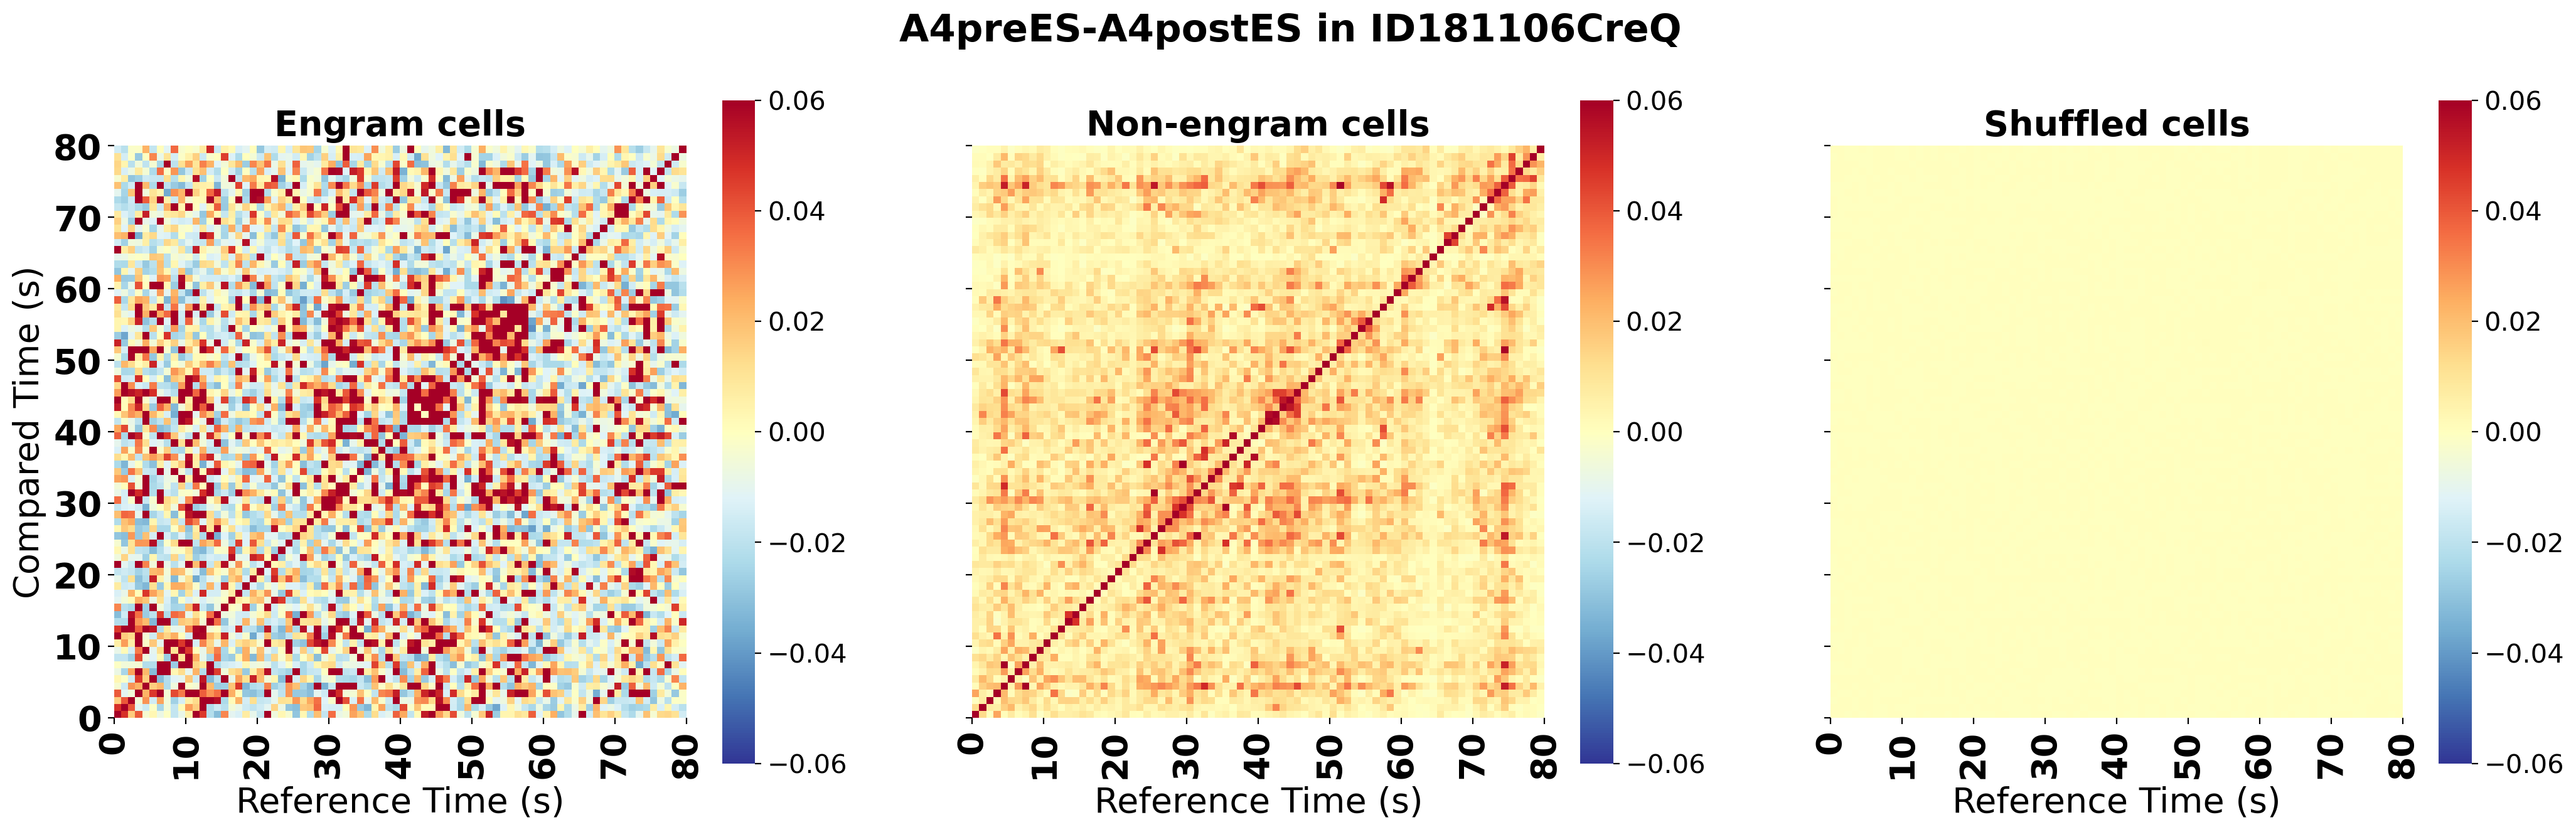

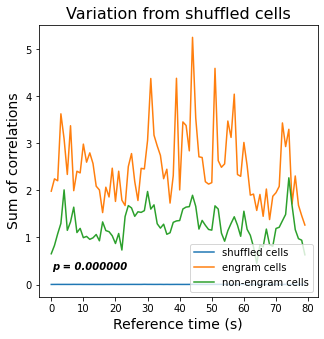

In [5]:
%%time

abs_sum_df_for_a1 = pd.DataFrame(0.0, columns=['shuffle cells', 'engram cells', 'non-engram cells'], index=const.ANIMAL_NAMES)
abs_sum_df_for_a4 = pd.DataFrame(0.0, columns=['shuffle cells', 'engram cells', 'non-engram cells'], index=const.ANIMAL_NAMES)

for animal_name in const.ANIMAL_NAMES:
    file_path = './resources/%s_Longitudinal_Traces.csv' % animal_name
    csv = CaImageCSV(file_path)
    
    shuffle_df, engram_df, non_engram_df = view_between_es_correlation('A1', csv)
    abs_sum_df_for_a1.loc[animal_name, 'shuffle cells']    = shuffle_df.abs().sum().mean()
    abs_sum_df_for_a1.loc[animal_name, 'engram cells']     = engram_df.abs().sum().mean()
    abs_sum_df_for_a1.loc[animal_name, 'non-engram cells'] = non_engram_df.abs().sum().mean()
    
    shuffle_df, engram_df, non_engram_df = result = view_between_es_correlation('A4', csv)
    abs_sum_df_for_a4.loc[animal_name, 'shuffle cells']    = shuffle_df.abs().sum().mean()
    abs_sum_df_for_a4.loc[animal_name, 'engram cells']     = engram_df.abs().sum().mean()
    abs_sum_df_for_a4.loc[animal_name, 'non-engram cells'] = non_engram_df.abs().sum().mean()